[INFO] Found 9 cube(s) in C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469:
 - jw01328-c1006_t014_miri_ch1-long_s3d.fits
 - jw01328-c1006_t014_miri_ch1-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch1-short_s3d.fits
 - jw01328-c1006_t014_miri_ch2-long_s3d.fits
 - jw01328-c1006_t014_miri_ch2-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch2-short_s3d.fits
 - jw01328-c1006_t014_miri_ch3-long_s3d.fits
 - jw01328-c1006_t014_miri_ch3-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch3-short_s3d.fits
[INFO] Available mini-cubes:
  ('CH1', 'short'): jw01328-c1006_t014_miri_ch1-short_s3d.fits
  ('CH1', 'medium'): jw01328-c1006_t014_miri_ch1-medium_s3d.fits
  ('CH1', 'long'): jw01328-c1006_t014_miri_ch1-long_s3d.fits
  ('CH2', 'short'): jw01328-c1006_t014_miri_ch2-short_s3d.fits
  ('CH2', 'medium'): jw01328-c1006_t014_miri_ch2-medium_s3d.fits
  ('CH2', 'long'): jw01328-c1006_t014_miri_ch2-long_s3d.fits
  ('CH3', 'short'): jw01328-c1006_t014_miri_ch3-short_s3d.fits
  ('CH3', 'medium'): jw01

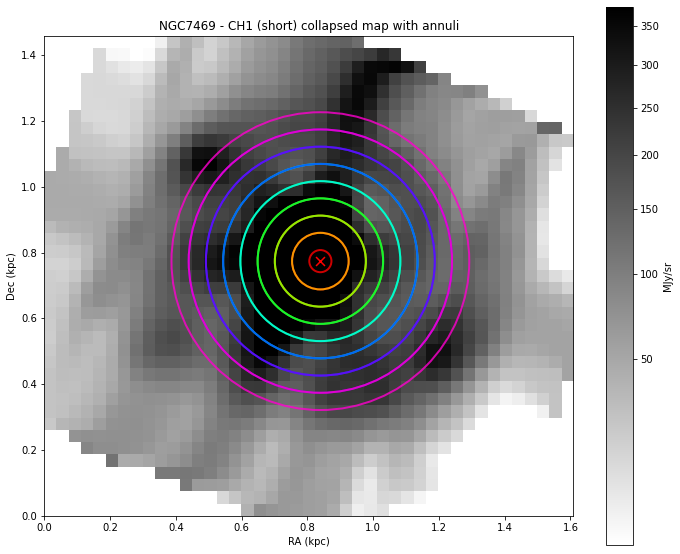

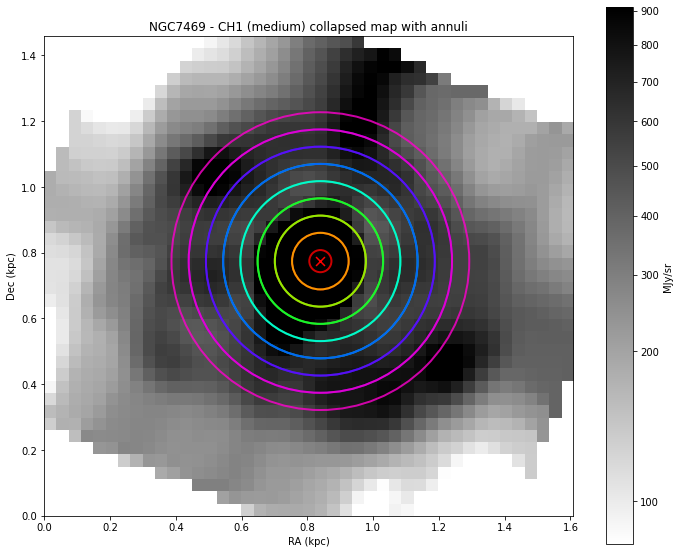

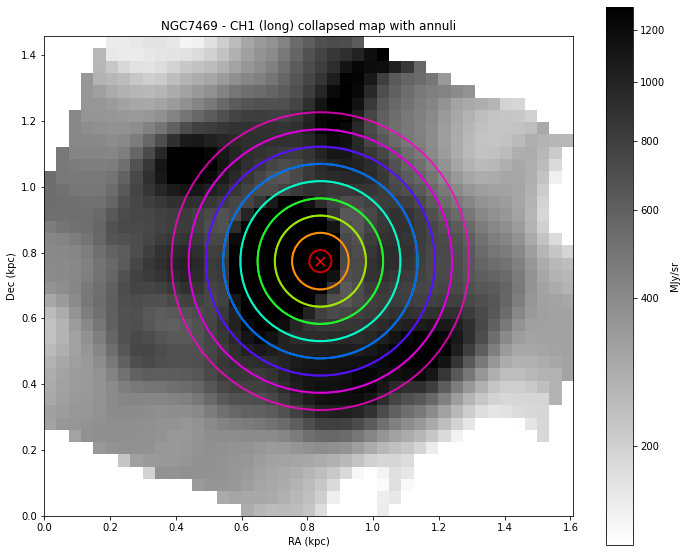

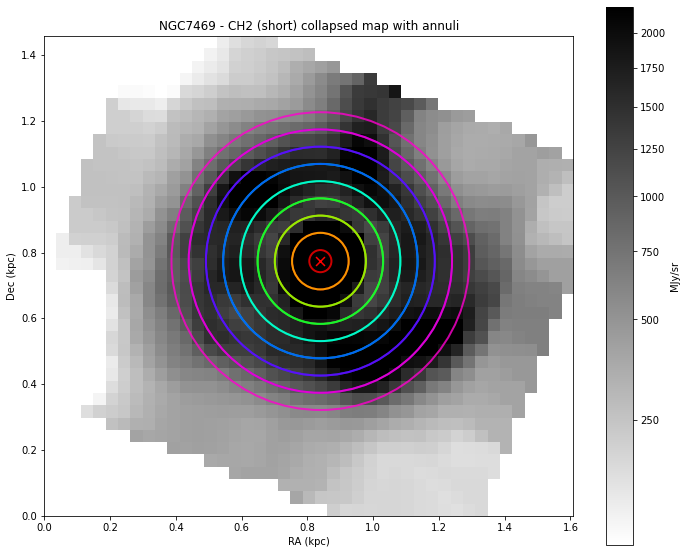

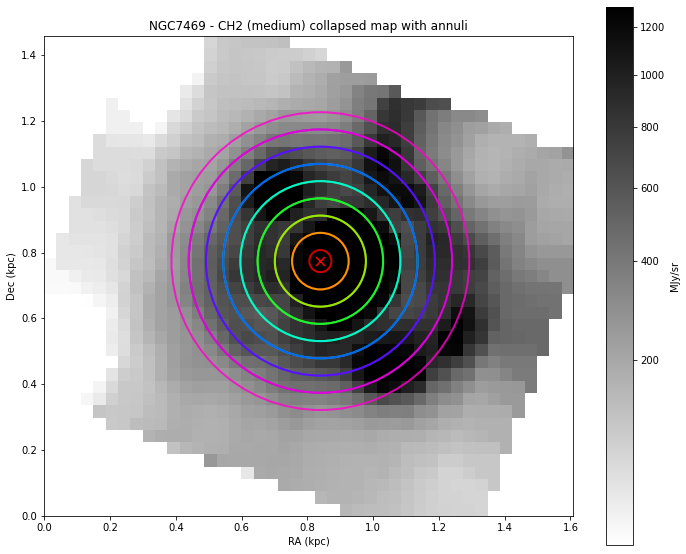

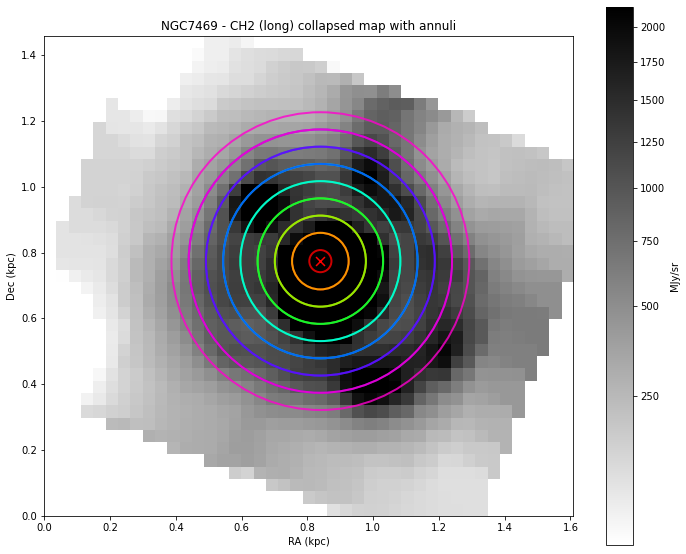

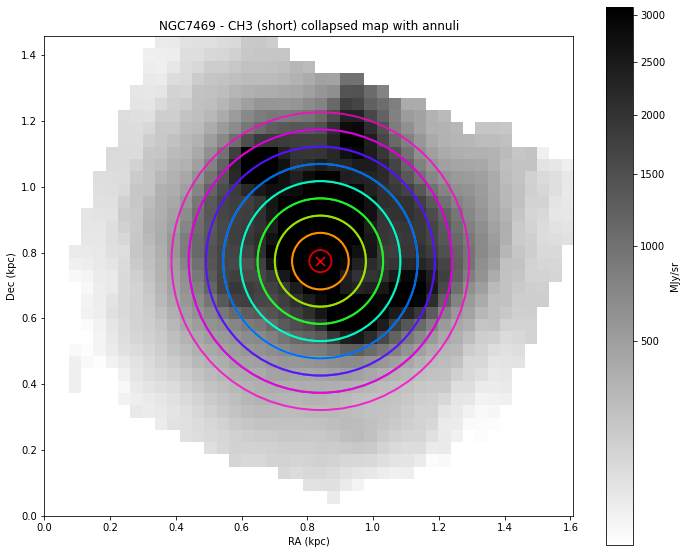

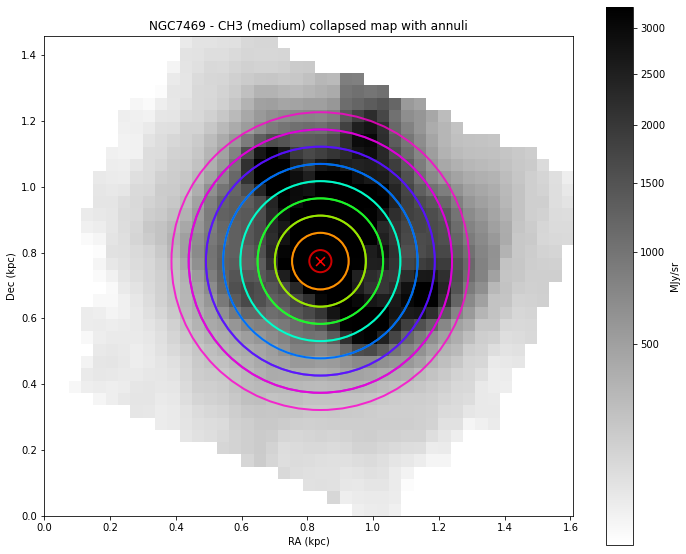

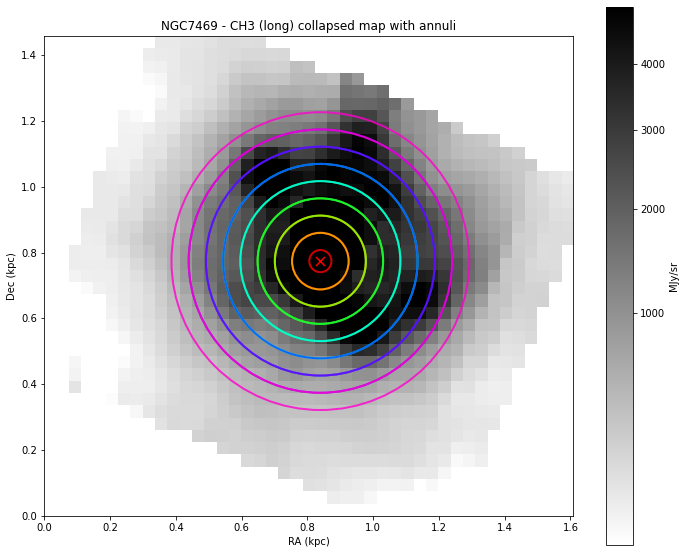

[INFO] Extracting annular spectra from each mini-cube and saving MultiSpecModel rings...
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring1.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring2.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring3.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring4.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring5.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring6.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring7.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring8.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring1.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring2.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring3.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring4.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring5.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring6.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring7.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring8.fits
[MultiSpecModel] Saved: NGC7469_CH1-long_Ring1.fits
[Mu

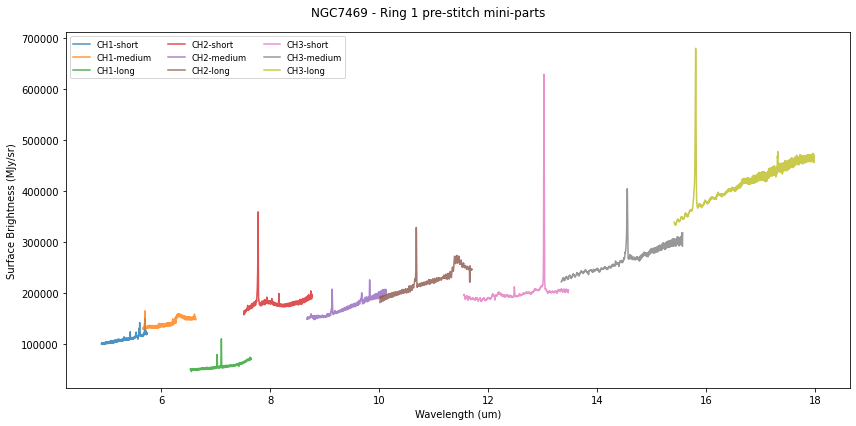

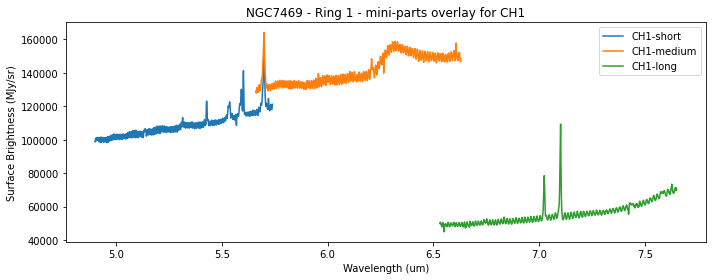

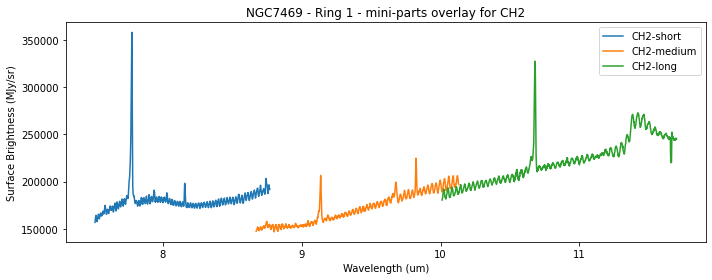

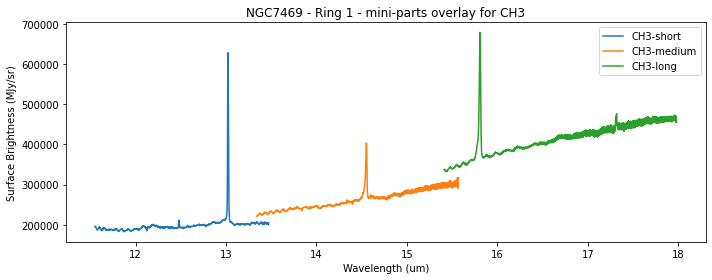

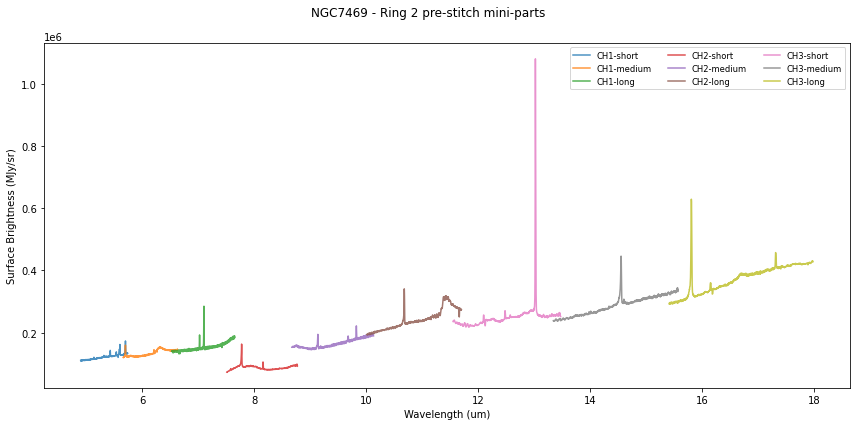

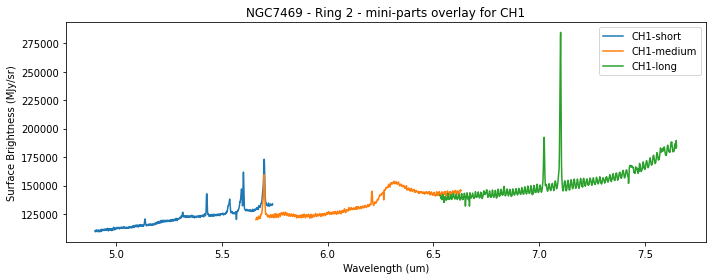

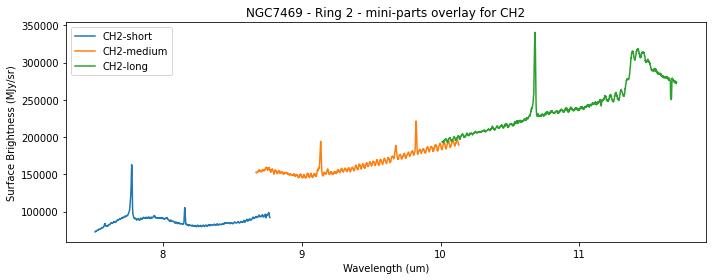

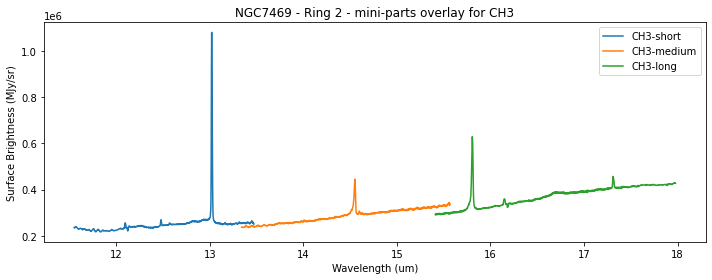

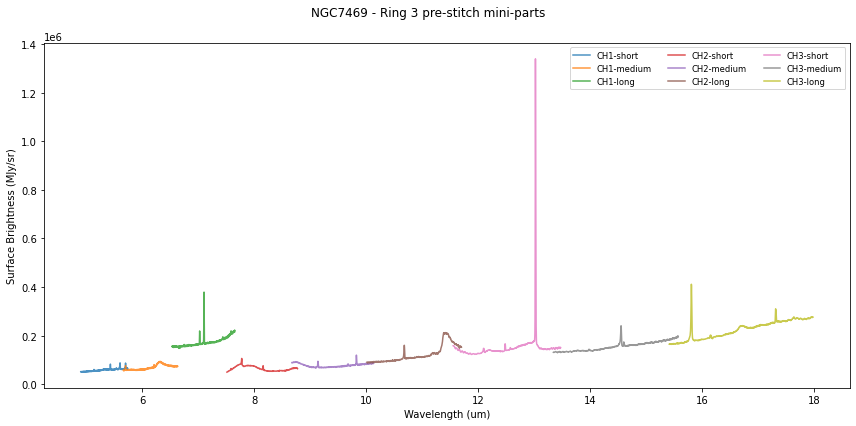

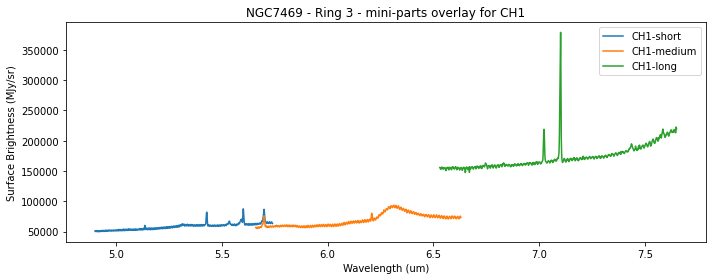

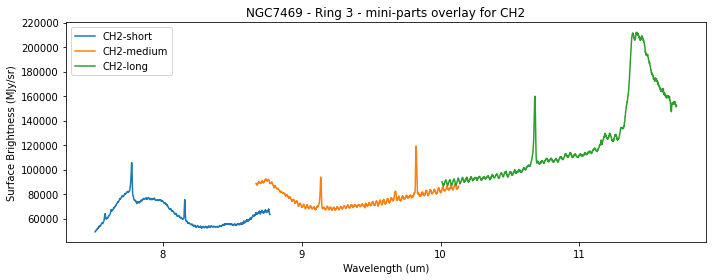

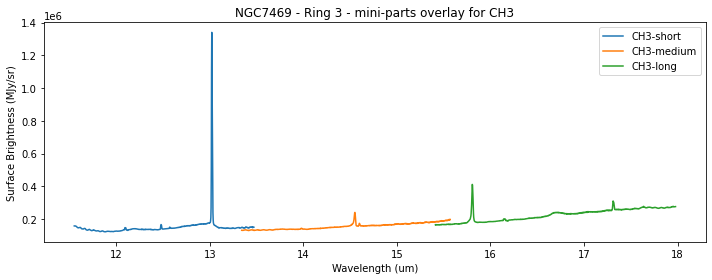

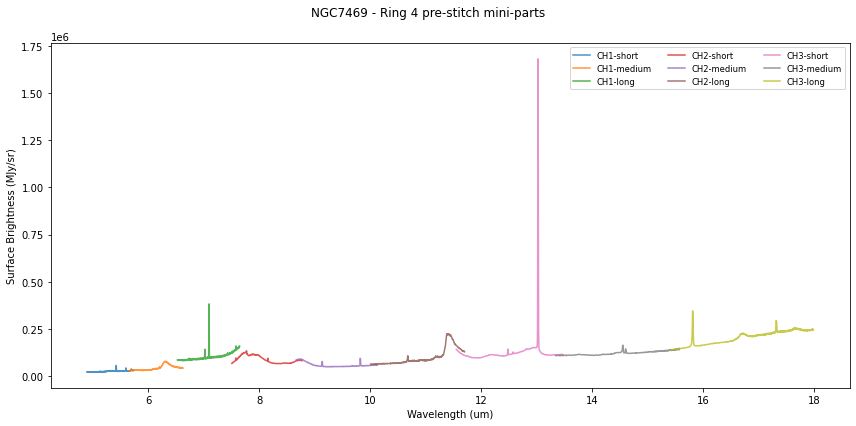

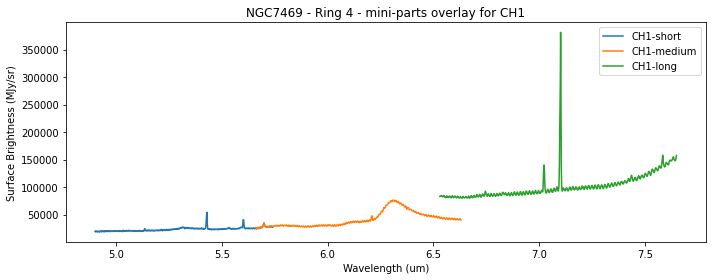

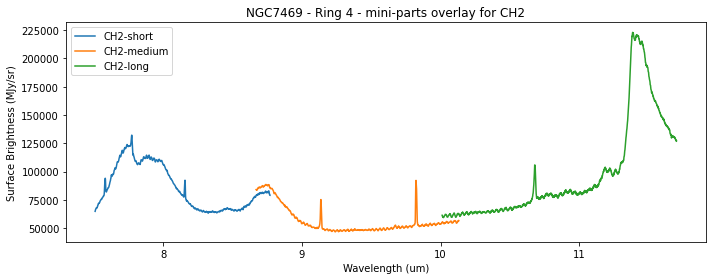

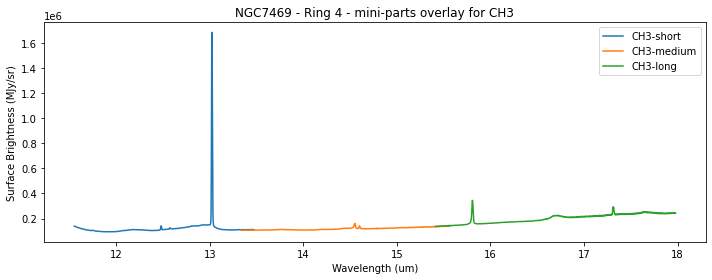

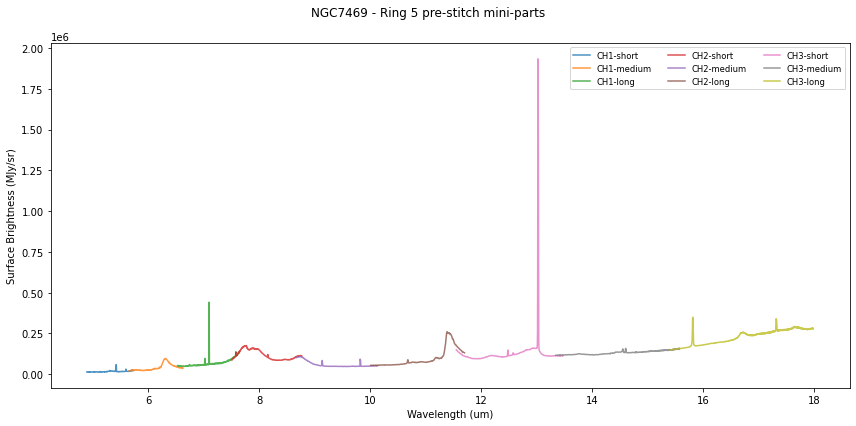

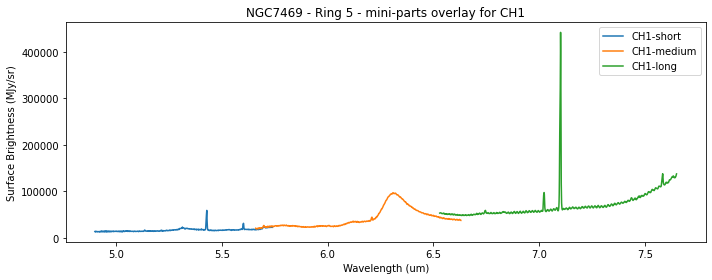

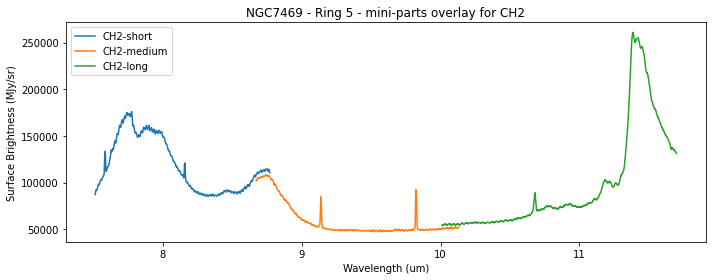

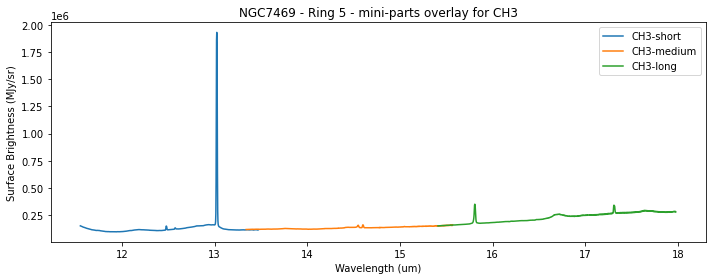

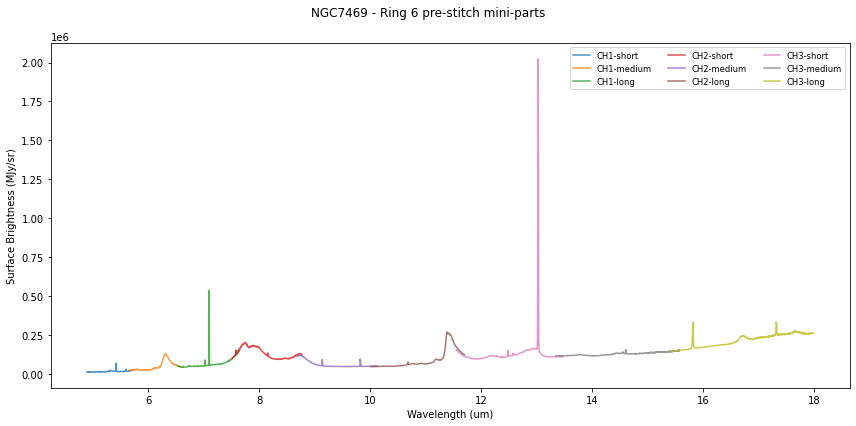

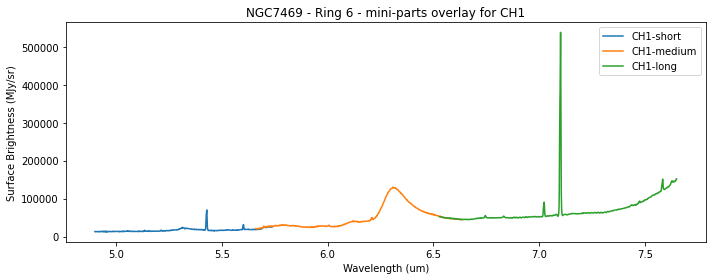

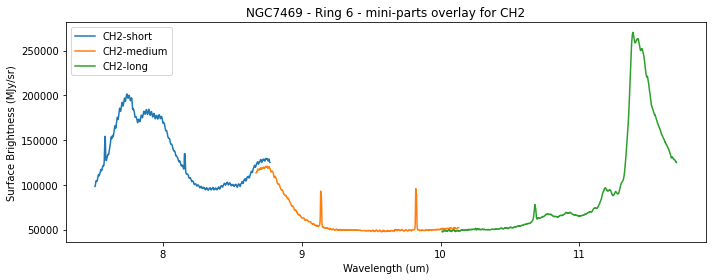

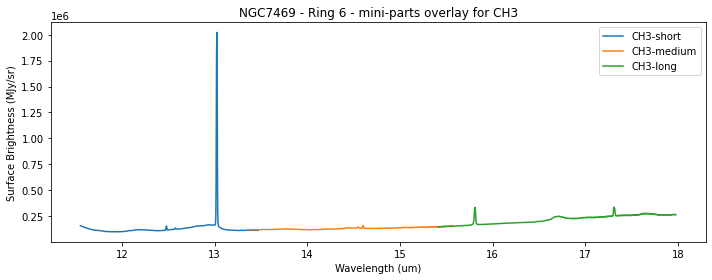

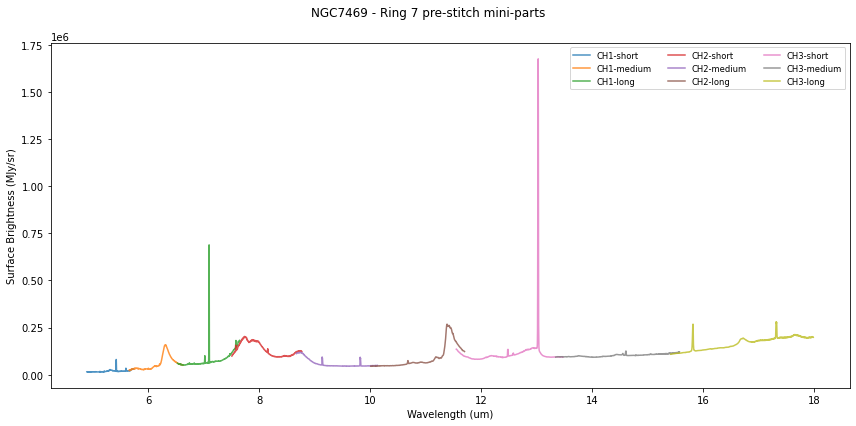

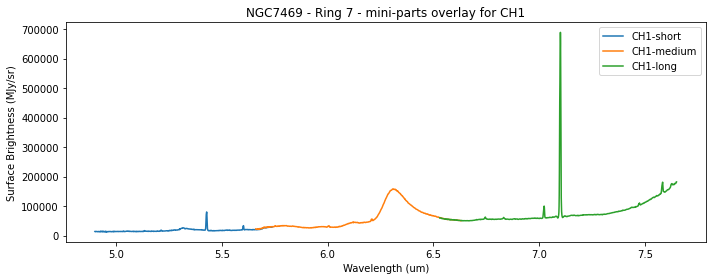

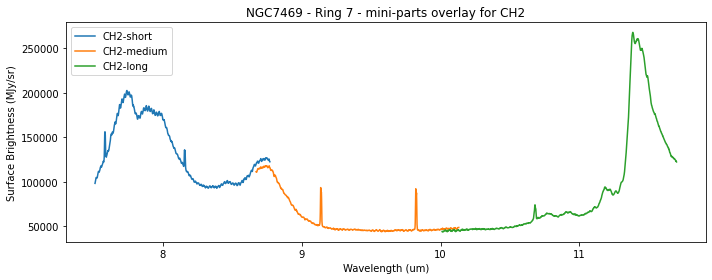

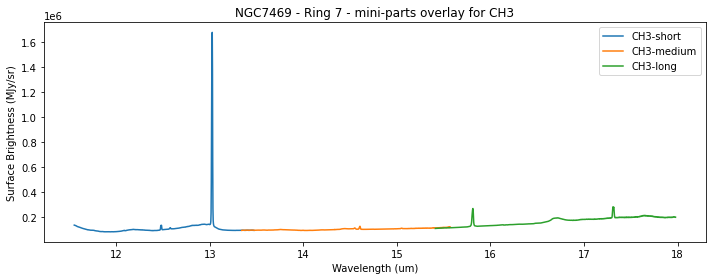

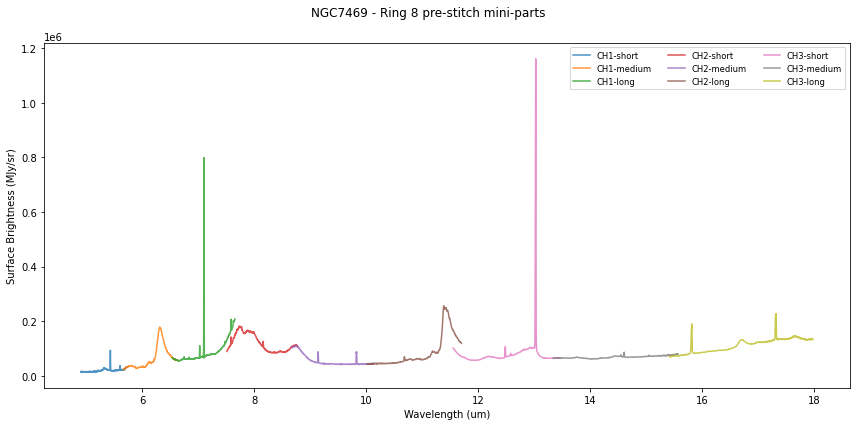

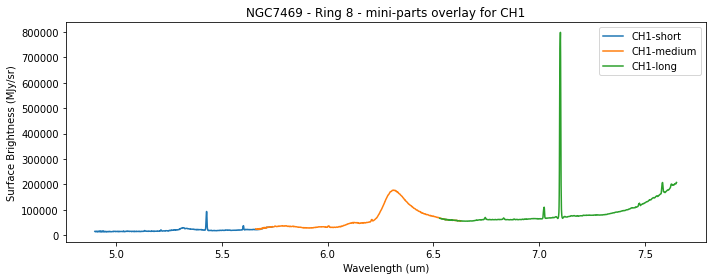

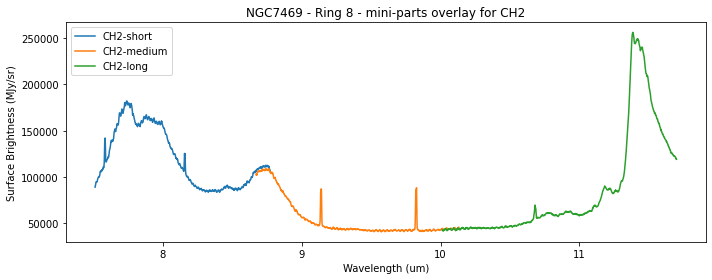

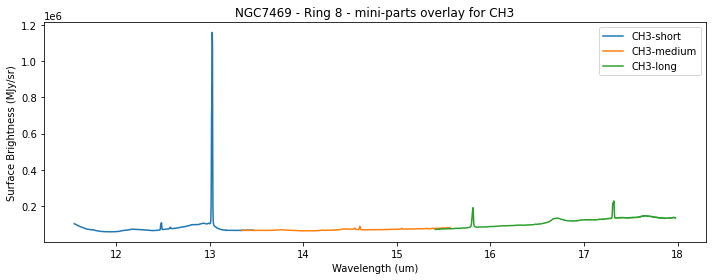

[INFO] Manual overlap-matched stitching of all mini-parts per ring ...
[STITCHED] Ring 1 → NGC7469_Ring1_stitched_manual.fits (8669 points)


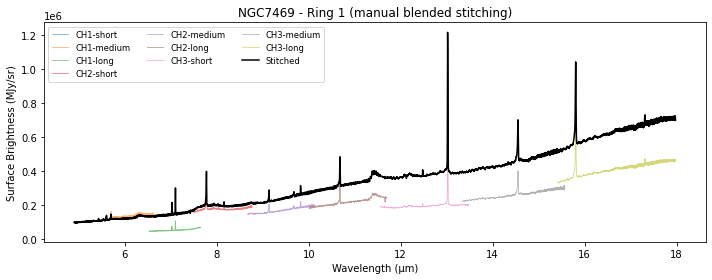

[STITCHED] Ring 2 → NGC7469_Ring2_stitched_manual.fits (8669 points)


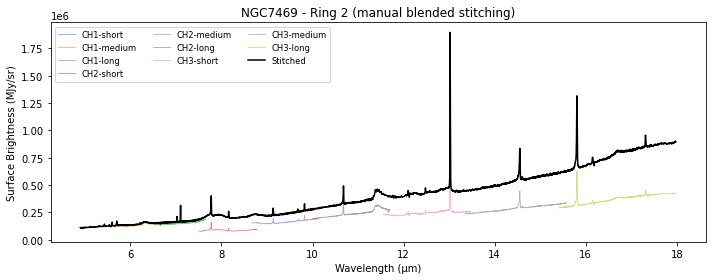

[STITCHED] Ring 3 → NGC7469_Ring3_stitched_manual.fits (8669 points)


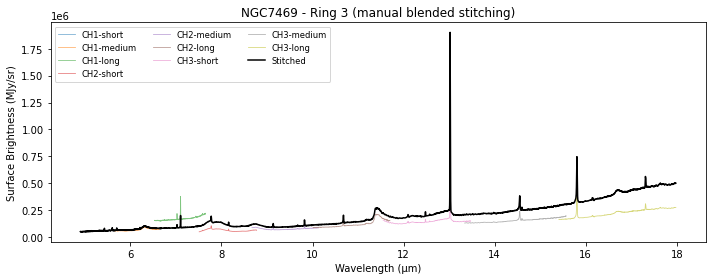

[STITCHED] Ring 4 → NGC7469_Ring4_stitched_manual.fits (8669 points)


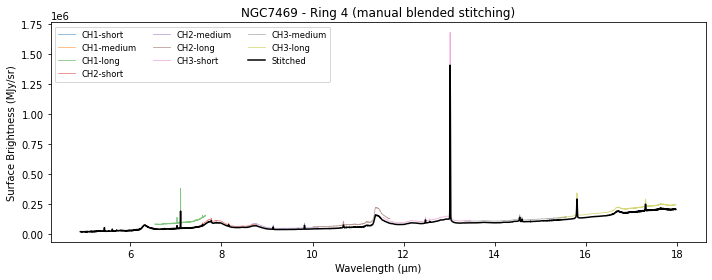

[STITCHED] Ring 5 → NGC7469_Ring5_stitched_manual.fits (8669 points)


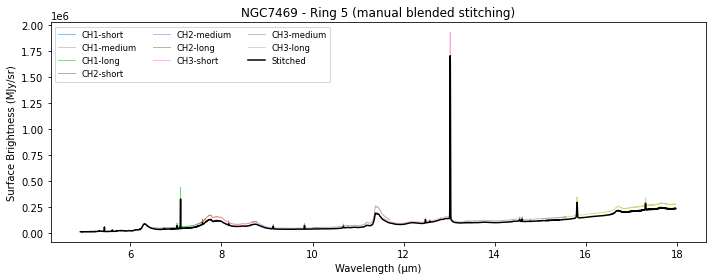

[STITCHED] Ring 6 → NGC7469_Ring6_stitched_manual.fits (8669 points)


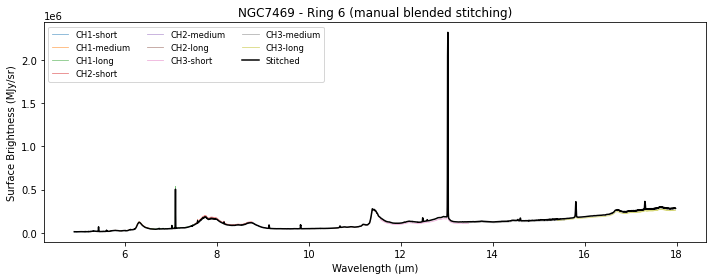

[STITCHED] Ring 7 → NGC7469_Ring7_stitched_manual.fits (8669 points)


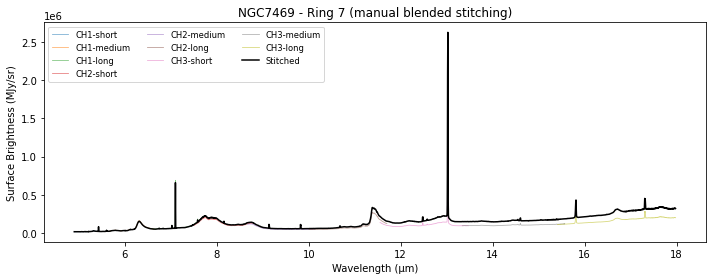

[STITCHED] Ring 8 → NGC7469_Ring8_stitched_manual.fits (8669 points)


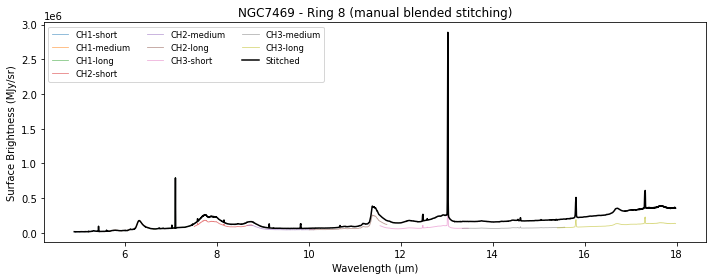

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Ring 1 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahfit.ecsv
The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Ring 2 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring2_pahfit.ecsv
The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Ring 3 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring3_pahfit.ecsv
The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Ring 4 completed: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring4_pahfit.ecsv
The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Ring 

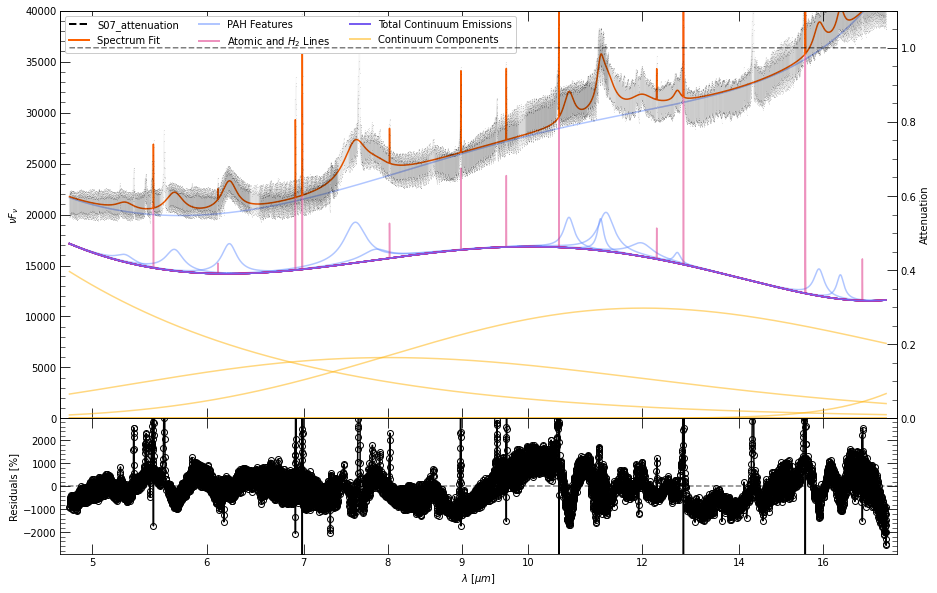

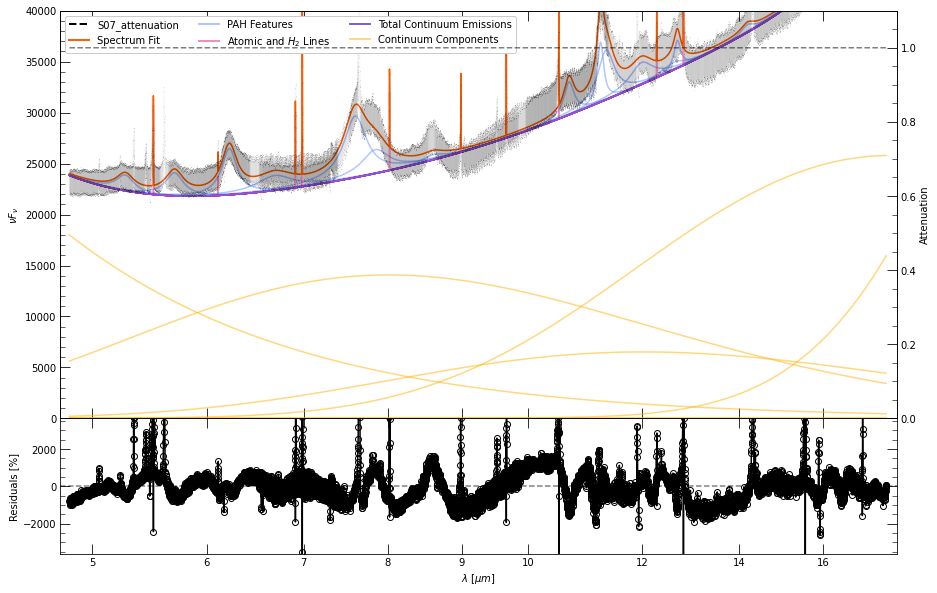

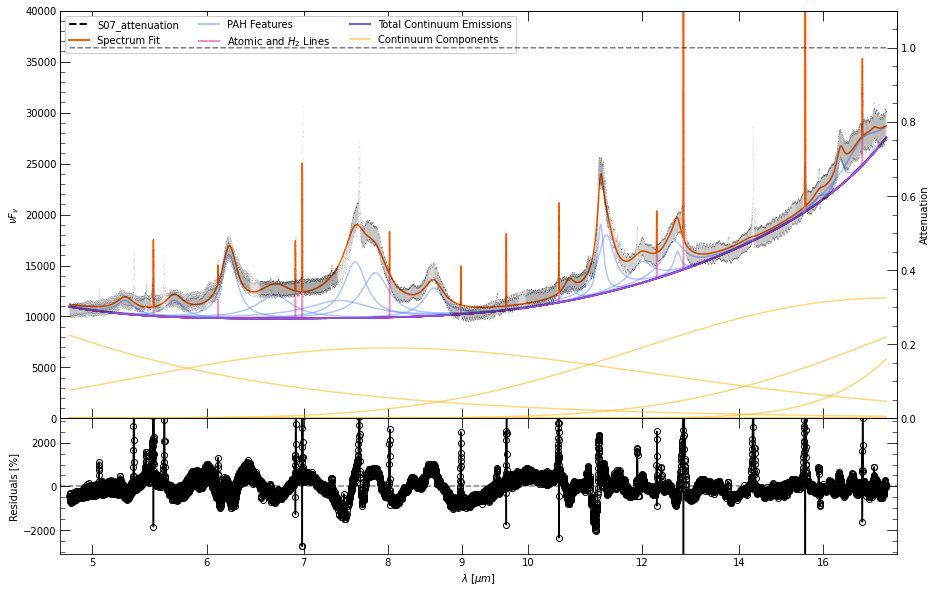

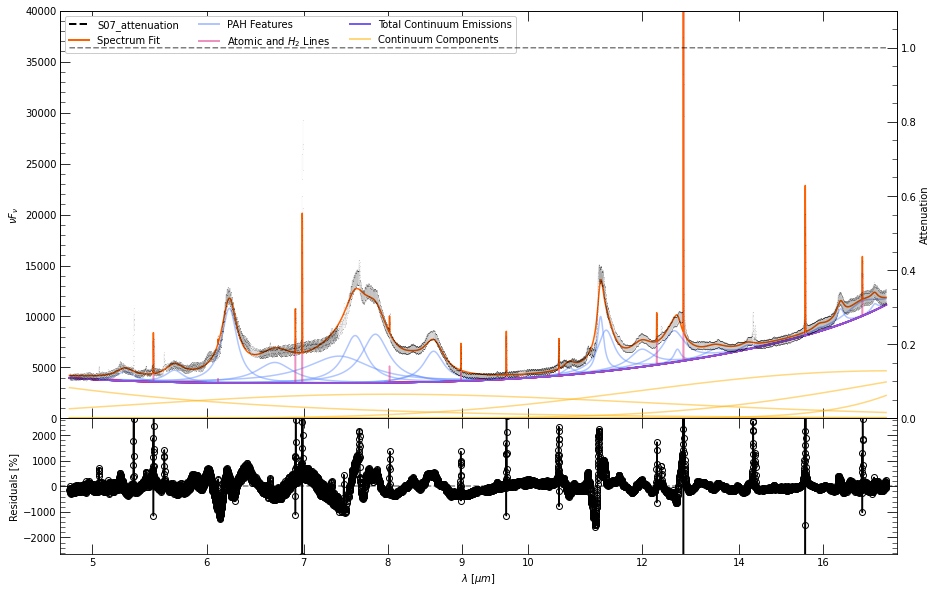

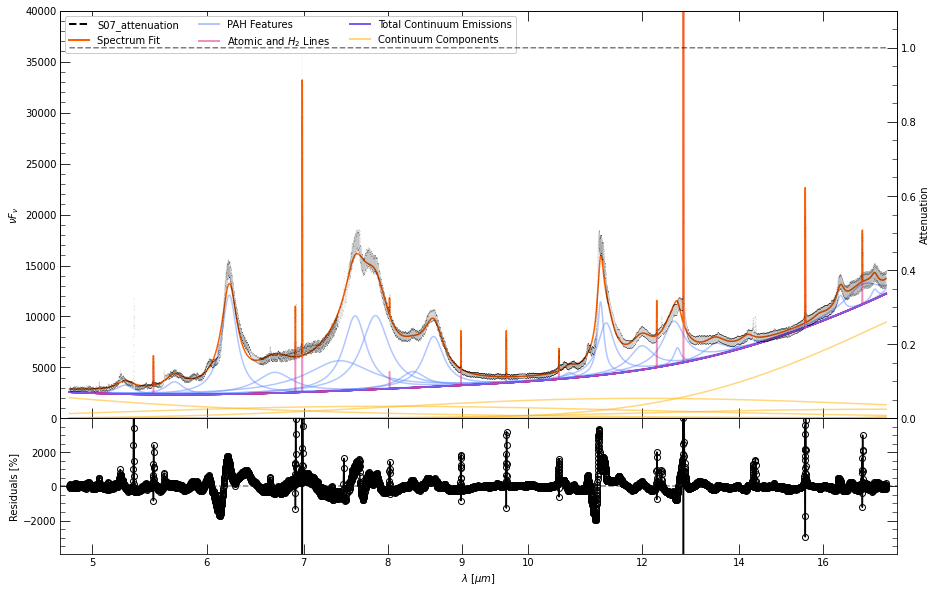

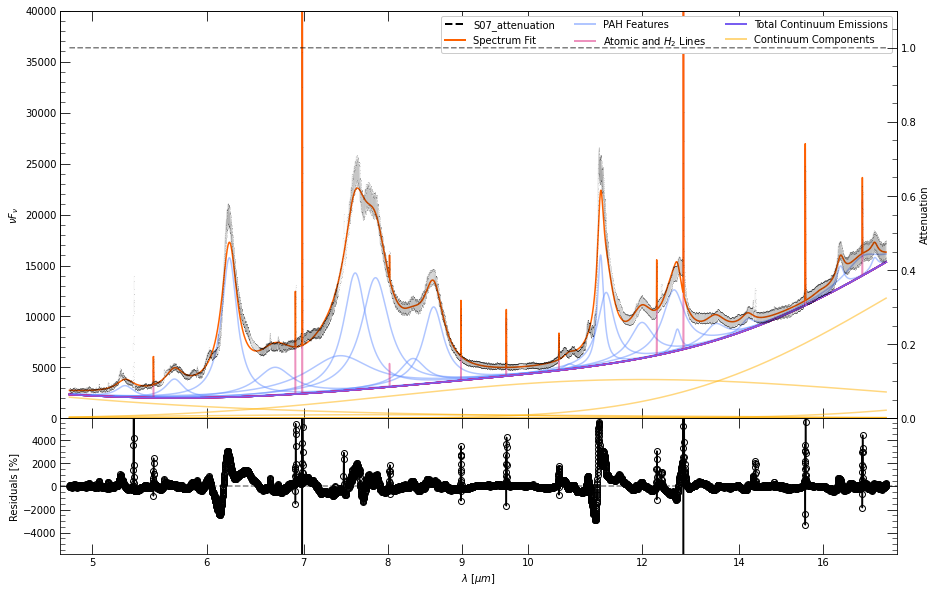

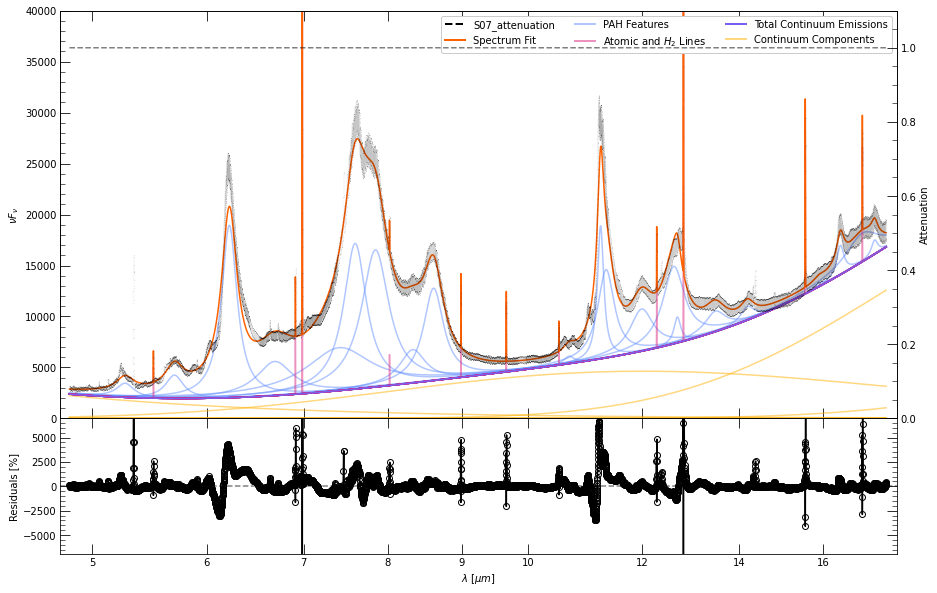

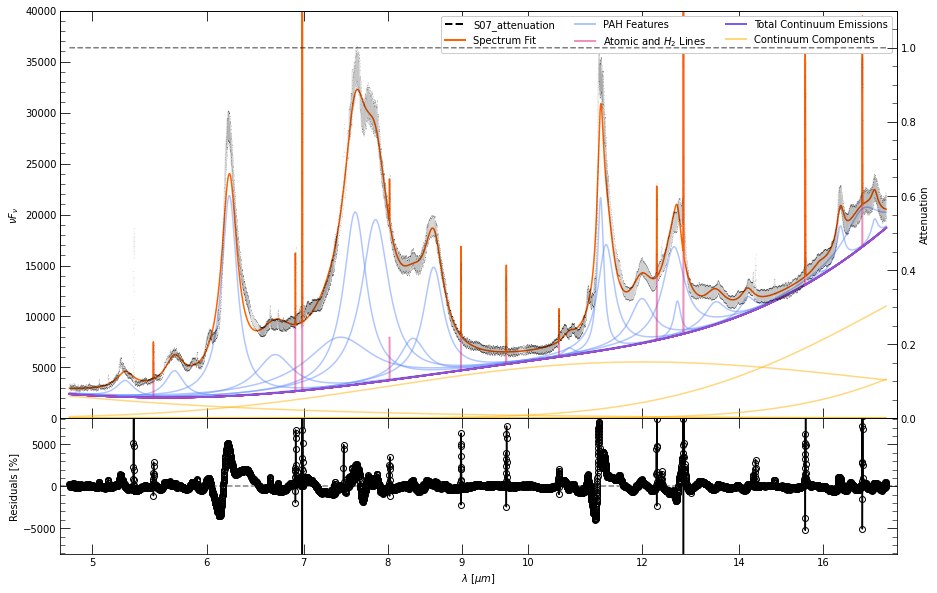

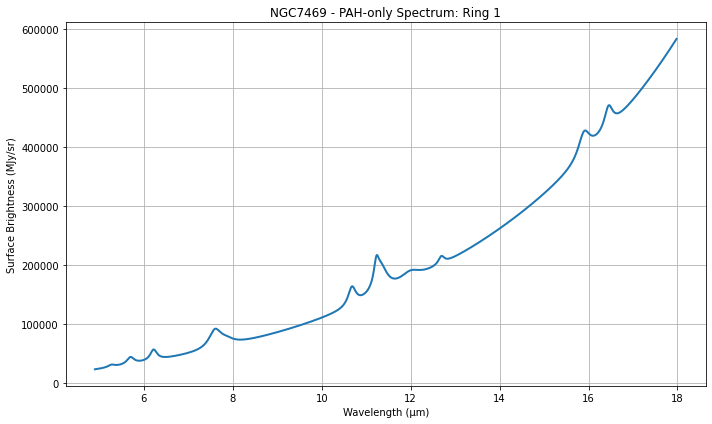

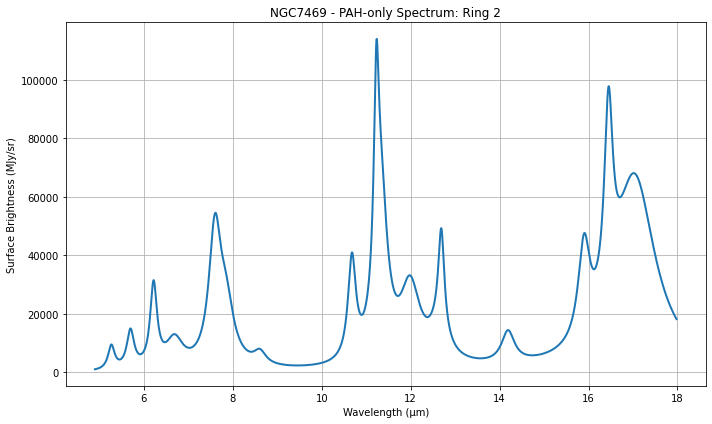

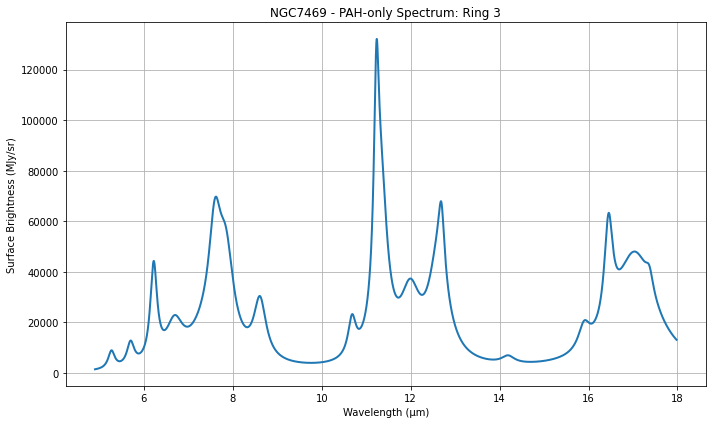

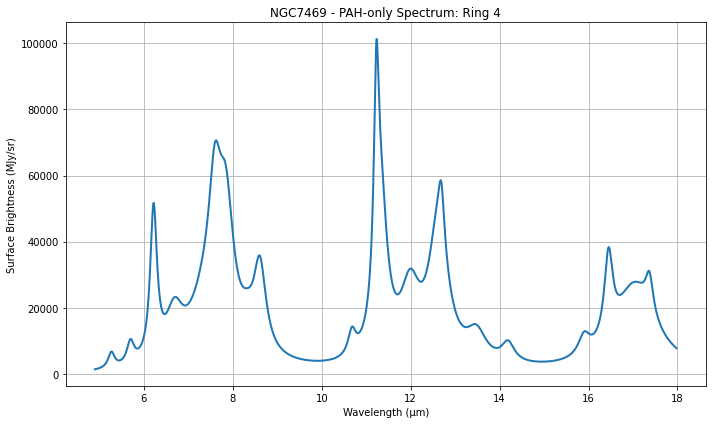

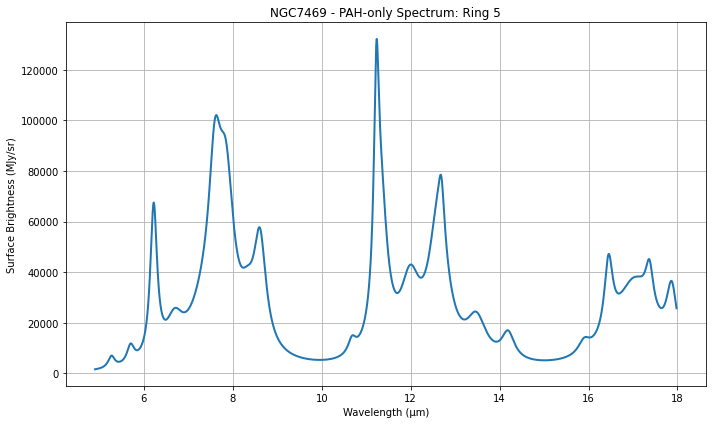

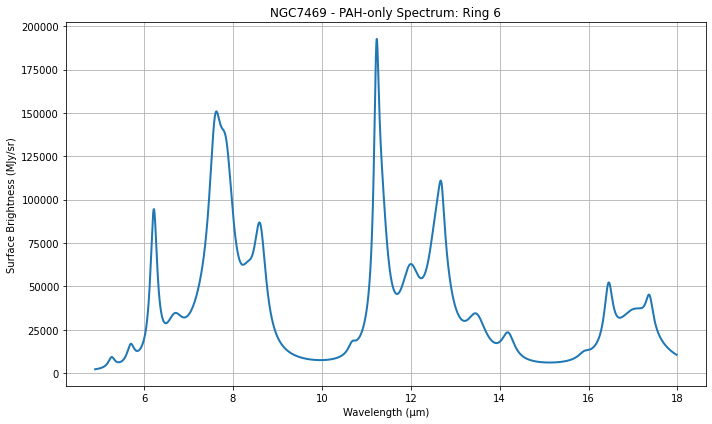

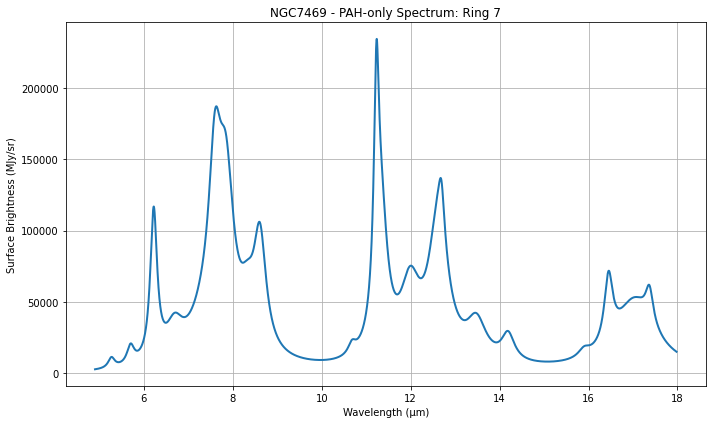

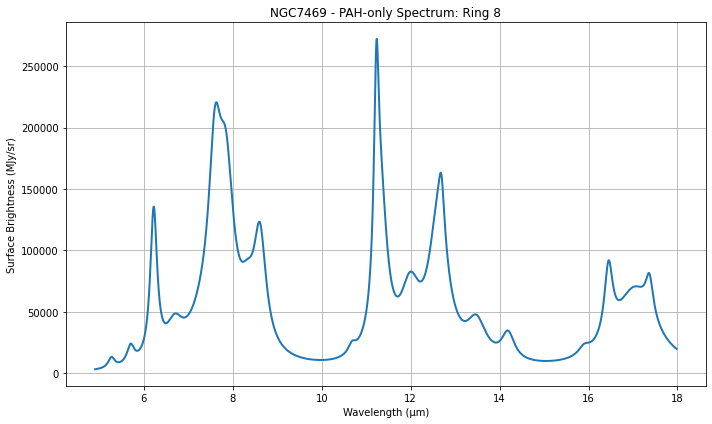

In [1]:
#!/usr/bin/env python3
"""
Approach D (manual stitching) + PAHFIT, with Windows-safe saves.

Fixes:
- Use context managers for FITS reads (memmap=False) so files close immediately.
- Override overwrite by pre-deleting via safe_overwrite(), then write with overwrite=False.
- Retry on PermissionError (WinError 32).
"""

import os, json, warnings, time
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import simple_norm
from astropy import units as u

import matplotlib.pyplot as plt
from matplotlib import colormaps
from photutils.aperture import aperture_photometry, CircularAnnulus

from jwst.datamodels import MultiSpecModel
# Combine1dStep import intentionally omitted from use (manual stitch only)

warnings.filterwarnings("ignore")

# ------------------- USER: select galaxy folder here -------------------
galaxy_folder = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
galaxy_name = galaxy_folder.name

# environment for JWST (optional)
os.environ['CRDS_PATH'] = os.path.expanduser("~/crds_cache")
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# ------------------- PARAMETERS (kept as in D) -------------------
pixel_scale_arcsec = 0.11
pixel_scale_pc = 37.41
pixel_scale_kpc = pixel_scale_pc / 1000.0

effective_fwhm = {'CH1': 0.22, 'CH2': 0.28, 'CH3': 0.66}  # arcsec
target_fwhm = 0.30  # NOTE: keeps D behavior; for science use 0.66
sigma_from_fwhm = lambda f: f / (2.0 * np.sqrt(2.0 * np.log(2.0)))

r0 = 0.9
step = 1.4
num_rings = 8
annuli_radii = [(r0 + i*step, r0 + (i+1)*step) for i in range(num_rings)]

# order for final stitching (per-ring): CH1 short/med/long, CH2..., CH3...
stitch_order = [
    ('CH1','short'), ('CH1','medium'), ('CH1','long'),
    ('CH2','short'), ('CH2','medium'), ('CH2','long'),
    ('CH3','short'), ('CH3','medium'), ('CH3','long'),
]

# ------------------- Windows-safe save helpers -------------------
def safe_overwrite(path: Path, retries: int = 6, sleep_s: float = 0.5) -> None:
    """
    If 'path' exists, try to delete it with brief retries (handles 'in use' on Windows).
    """
    path = Path(path)
    if not path.exists():
        return
    for _ in range(retries):
        try:
            path.unlink()
            return
        except PermissionError:
            time.sleep(sleep_s)
    # Last attempt: rename old file to a temp name (may still fail if locked)
    try:
        tmp = path.with_suffix(path.suffix + ".old")
        if tmp.exists():
            tmp.unlink(missing_ok=True)
        path.rename(tmp)
    except Exception:
        # If still locked, we propagate the PermissionError on write
        pass

def save_model_robust(model: MultiSpecModel, path_out: Path, retries: int = 6, sleep_s: float = 0.5) -> None:
    """
    Save a JWST datamodel robustly on Windows by pre-deleting and retrying on PermissionError.
    """
    path_out = Path(path_out)
    safe_overwrite(path_out, retries=retries, sleep_s=sleep_s)
    for i in range(retries):
        try:
            # Use overwrite=False since we pre-deleted it
            model.save(str(path_out), overwrite=False)
            return
        except PermissionError:
            time.sleep(sleep_s)
    # final attempt (let exception raise if still locked)
    model.save(str(path_out), overwrite=False)

# ------------------- Discovery utilities -------------------
def find_cube_for(ch_label, part_label, all_files):
    ch_frag = ch_label.lower()
    part_frag = part_label.lower()
    for f in all_files:
        name = f.name.lower()
        if ch_frag in name and part_frag in name:
            return f
    for f in all_files:
        name = f.name.lower()
        if ch_frag in name and ('shortmediumlong' in name or 'shortmedlong' in name or 'shortmedium' in name):
            return f
    return None

# ------------------- Save ring as MultiSpecModel (Windows-safe) -------------------
def save_ring_multispec(filename_path: Path, wavelengths, flux):
    n = len(wavelengths)
    spec_table = Table()
    spec_table['WAVELENGTH'] = Column(wavelengths, unit='um')
    spec_table['FLUX'] = Column(flux, unit='MJy/sr')
    spec_table['FLUX_ERROR'] = Column(np.ones(n)*0.1, unit='MJy/sr')
    spec_table['DQ'] = np.zeros(n, dtype=np.uint32)
    for col in ['FLUX_VAR_POISSON','FLUX_VAR_RNOISE','FLUX_VAR_FLAT','SURF_BRIGHT','SB_ERROR',
                'SB_VAR_POISSON','SB_VAR_RNOISE','SB_VAR_FLAT','BACKGROUND','BKGD_ERROR','BKGD_VAR_POISSON',
                'BKGD_VAR_RNOISE','BKGD_VAR_FLAT','NPIXELS']:
        spec_table[col] = np.zeros(n)
    model = MultiSpecModel()
    model.spec = [{"spec_table": spec_table}]
    model.meta.instrument.name = 'MIRI'
    model.meta.exposure.type = 'MIR_MRS'
    model.meta.exposure.exposure_time = 1.0
    model.meta.bunit_data = 'MJy/sr'
    save_model_robust(model, filename_path)
    print(f"[MultiSpecModel] Saved: {filename_path.name}")

# ------------------- Gather available cubes -------------------
all_cube_files = sorted(galaxy_folder.glob("*_s3d.fits"))
if len(all_cube_files) == 0:
    raise FileNotFoundError(f"No '*_s3d.fits' files found in {galaxy_folder}")

print(f"[INFO] Found {len(all_cube_files)} cube(s) in {galaxy_folder}:")
for f in all_cube_files:
    print(" -", f.name)

mini_cubes = {}
for ch, part in stitch_order:
    found = find_cube_for(ch, part, all_cube_files)
    if found is not None:
        mini_cubes[(ch, part)] = found

for f in all_cube_files:
    name = f.name.lower()
    if 'ch1' in name and 'shortmediumlong' in name:
        mini_cubes[('CH1','full')] = f
    if 'ch2' in name and 'shortmediumlong' in name:
        mini_cubes[('CH2','full')] = f
    if 'ch3' in name and 'shortmediumlong' in name:
        mini_cubes[('CH3','full')] = f

print("[INFO] Available mini-cubes:")
for k,v in mini_cubes.items():
    print(f"  {k}: {v.name}")

# ------------------- Load, PSF-match, collapse, crop -------------------
cubes = {}
collapsed_map = {}
min_shape = None

for (ch, part), filepath in mini_cubes.items():
    with fits.open(filepath, memmap=False) as hdul:
        data = hdul[1].data.astype(np.float64)
        header = hdul[1].header
        wl_start = header.get('CRVAL3', header.get('CRVAL', None))
        wl_step  = header.get('CDELT3', header.get('CDELT', None))
        if wl_start is None or wl_step is None:
            raise KeyError(f"No CRVAL3/CDELT3 in header of {filepath.name}")
        wavelengths = wl_start + np.arange(data.shape[0]) * wl_step

    eff_fwhm = effective_fwhm.get(ch, None)
    if eff_fwhm is not None and eff_fwhm < target_fwhm:
        sigma_target = sigma_from_fwhm(target_fwhm)
        sigma_eff = sigma_from_fwhm(eff_fwhm)
        sigma_conv_arcsec = float(np.sqrt(max(sigma_target**2 - sigma_eff**2, 0.0)))
        sigma_pix = sigma_conv_arcsec / pixel_scale_arcsec
        data = np.array([
            convolve(plane, Gaussian2DKernel(sigma_pix), boundary='extend', nan_treatment='interpolate')
            for plane in data
        ])
        print(f"[{ch}|{part}] PSF matched -> target {target_fwhm}\" (sigma_pix={sigma_pix:.3f})")

    collapsed = np.nanmean(data, axis=0)
    cubes[(ch,part)] = (data, wavelengths)
    collapsed_map[(ch,part)] = collapsed
    if min_shape is None:
        min_shape = collapsed.shape
    else:
        min_shape = (min(min_shape[0], collapsed.shape[0]),
                     min(min_shape[1], collapsed.shape[1]))

# center-crop
for key in list(collapsed_map.keys()):
    img = collapsed_map[key]
    y_trim = (img.shape[0] - min_shape[0]) // 2
    x_trim = (img.shape[1] - min_shape[1]) // 2
    collapsed_map[key] = img[y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]]
    data, wl = cubes[key]
    cubes[key] = (data[:, y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]], wl)

# common center
combined_image = sum(img - np.nanmin(img) for img in collapsed_map.values())
mask = np.isfinite(combined_image)
total = np.nansum(combined_image[mask])
y_idx, x_idx = np.indices(combined_image.shape)
x_center = np.nansum(x_idx[mask] * combined_image[mask]) / total
y_center = np.nansum(y_idx[mask] * combined_image[mask]) / total
print(f"[CENTER] common center (px): x={x_center:.2f}, y={y_center:.2f}")

# ------------------- QA overlays -------------------
cmap = colormaps.get_cmap('hsv')
for key, img in collapsed_map.items():
    ch, part = key
    plt.figure(figsize=(10,8))
    norm = simple_norm(img, 'sqrt', percent=88)
    extent_x_kpc = img.shape[1] * pixel_scale_kpc
    extent_y_kpc = img.shape[0] * pixel_scale_kpc
    plt.imshow(img, origin='lower', cmap='binary', norm=norm,
               extent=[0, extent_x_kpc, 0, extent_y_kpc])
    plt.colorbar(label='MJy/sr')
    annuli_kpc = [(r_in*pixel_scale_kpc, r_out*pixel_scale_kpc) for r_in,r_out in annuli_radii]
    cx_kpc = x_center * pixel_scale_kpc
    cy_kpc = y_center * pixel_scale_kpc
    for i,(rin, rout) in enumerate(annuli_kpc):
        ann = CircularAnnulus((cx_kpc, cy_kpc), r_in=rin, r_out=rout)
        ann.plot(color=cmap(i/len(annuli_kpc)), lw=2, alpha=0.8)
    plt.scatter(cx_kpc, cy_kpc, color='red', marker='x', s=80)
    plt.title(f"{galaxy_name} - {ch} ({part}) collapsed map with annuli")
    plt.xlabel("RA (kpc)"); plt.ylabel("Dec (kpc)")
    plt.tight_layout(); plt.show()

# ------------------- Extract annuli & save per-mini-part rings -------------------
print("[INFO] Extracting annular spectra from each mini-cube and saving MultiSpecModel rings...")
for (ch, part), (data, wavelengths) in cubes.items():
    for i, (r_in, r_out) in enumerate(annuli_radii):
        ann_ap = CircularAnnulus((x_center, y_center), r_in=r_in, r_out=r_out)
        # aperture_photometry returns a table-like row; we collect sums per slice
        flux = np.array([aperture_photometry(plane, ann_ap)['aperture_sum'][0] for plane in data], dtype=float)
        ring_idx = i+1
        ring_filename = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_idx}.fits"
        save_ring_multispec(ring_filename, wavelengths, flux)

# ------------------- Pre-stitch plots -------------------
for ring_number in range(1, num_rings+1):
    plt.figure(figsize=(12, 6)); plt.suptitle(f"{galaxy_name} - Ring {ring_number} pre-stitch mini-parts")
    ax1 = plt.subplot(1,1,1)
    for (ch, part), (data, wavelengths) in cubes.items():
        ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
        if not ring_file.exists(): continue
        # MultiSpecModel reads close internally; no lingering handle
        model = MultiSpecModel(str(ring_file))
        tbl = model.spec[0].spec_table
        ax1.plot(tbl['WAVELENGTH'], tbl['FLUX'], label=f"{ch}-{part}", alpha=0.8)
    ax1.set_xlabel("Wavelength (um)"); ax1.set_ylabel("Surface Brightness (MJy/sr)")
    ax1.legend(ncol=3, fontsize='small'); plt.tight_layout(); plt.show()

    for ch in ['CH1','CH2','CH3']:
        plt.figure(figsize=(10,4))
        for part in ['short','medium','long','full']:
            ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
            if not ring_file.exists(): continue
            model = MultiSpecModel(str(ring_file)); tbl = model.spec[0].spec_table
            plt.plot(tbl['WAVELENGTH'], tbl['FLUX'], label=f"{ch}-{part}")
        plt.title(f"{galaxy_name} - Ring {ring_number} - mini-parts overlay for {ch}")
        plt.xlabel("Wavelength (um)"); plt.ylabel("Surface Brightness (MJy/sr)")
        plt.legend(); plt.tight_layout(); plt.show()

# ------------------- MANUAL CONTINUITY-STITCHING -------------------
from scipy.interpolate import interp1d

def join_spectra(w1, f1, w2, f2):
    if w1[0] > w1[-1]: w1, f1 = w1[::-1], f1[::-1]
    if w2[0] > w2[-1]: w2, f2 = w2[::-1], f2[::-1]
    overlap_start = max(w1[0], w2[0]); overlap_end = min(w1[-1], w2[-1])
    if not (overlap_end > overlap_start):
        return np.concatenate([w1, w2]), np.concatenate([f1, f2])
    m1 = (w1 >= overlap_start) & (w1 <= overlap_end)
    m2 = (w2 >= overlap_start) & (w2 <= overlap_end)
    if np.sum(m1) < 3 or np.sum(m2) < 3:
        return np.concatenate([w1, w2]), np.concatenate([f1, f2])
    f1_mean = np.nanmedian(f1[m1]); f2_mean = np.nanmedian(f2[m2])
    scale = f1_mean / f2_mean if (f2_mean != 0 and np.isfinite(f2_mean)) else 1.0
    f2_scaled = f2 * scale
    i1 = interp1d(w1, f1, bounds_error=False, fill_value="extrapolate")
    i2 = interp1d(w2, f2_scaled, bounds_error=False, fill_value="extrapolate")
    w_overlap = np.linspace(overlap_start, overlap_end, 50)
    blend = np.linspace(0, 1, 50)
    f_overlap = (1 - blend) * i1(w_overlap) + blend * i2(w_overlap)
    w = np.concatenate([w1[w1 < overlap_start], w_overlap, w2[w2 > overlap_end]])
    f = np.concatenate([f1[w1 < overlap_start], f_overlap, f2_scaled[w2 > overlap_end]])
    return w, f

print("[INFO] Manual overlap-matched stitching of all mini-parts per ring ...")
for ring_number in range(1, num_rings + 1):
    ring_parts = []
    for (ch, part) in stitch_order:
        ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
        if not ring_file.exists(): continue
        model = MultiSpecModel(str(ring_file))
        tab = model.spec[0].spec_table
        ring_parts.append((np.array(tab['WAVELENGTH']), np.array(tab['FLUX']), f"{ch}-{part}"))
    if len(ring_parts) == 0:
        print(f"[SKIP] Ring {ring_number}: no parts found."); continue
    ring_parts.sort(key=lambda x: x[0][0])
    w_comb, f_comb = ring_parts[0][0], ring_parts[0][1]
    for j in range(1, len(ring_parts)):
        w_next, f_next, label = ring_parts[j]
        w_comb, f_comb = join_spectra(w_comb, f_comb, w_next, f_next)
    stitched_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}_stitched_manual.fits"
    # Safe overwrite for stitched file
    safe_overwrite(stitched_file)
    tab = Table()
    tab['wavelength'] = Column(w_comb, unit='um')
    tab['flux'] = Column(f_comb, unit='MJy/sr')
    # Table.write does its own open/close; still guard with try/except
    for _ in range(6):
        try:
            tab.write(stitched_file, format='fits', overwrite=False)
            break
        except PermissionError:
            time.sleep(0.5)
    else:
        tab.write(stitched_file, format='fits', overwrite=False)
    print(f"[STITCHED] Ring {ring_number} → {stitched_file.name} ({len(w_comb)} points)")

    # Diagnostic plot
    plt.figure(figsize=(10,4))
    for w, f, label in ring_parts:
        plt.plot(w, f, alpha=0.6, lw=0.8, label=label)
    plt.plot(w_comb, f_comb, color='black', lw=1.5, label='Stitched')
    plt.xlabel("Wavelength (μm)"); plt.ylabel("Surface Brightness (MJy/sr)")
    plt.title(f"{galaxy_name} - Ring {ring_number} (manual blended stitching)")
    plt.legend(fontsize='small', ncol=3); plt.tight_layout(); plt.show()

# ------------------------- PAHFIT: fit + PAH-only (appended) -------------------------
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty
from pahfit.modelj import Model
import astropy.units as u

def run_pahfit_for_galaxy(galaxy_folder: Path, n_rings: int = num_rings, redshift: float = 0.016268):
    """
    Runs PAHFIT and PAH-only extraction for stitched manual spectra:
    expects {galaxy_name}_Ring{i}_stitched_manual.fits in the folder.
    Saves ECSV results in PAHFIT_results/ and PAH-only FITS in the galaxy folder.
    """
    galaxy_folder = Path(galaxy_folder)
    galaxy_name = galaxy_folder.name
    results_dir = galaxy_folder / "PAHFIT_results"
    results_dir.mkdir(exist_ok=True)

    # 1) PAHFIT per ring on stitched manual spectra
    for i in range(1, n_rings + 1):
        fits_file = galaxy_folder / f"{galaxy_name}_Ring{i}_stitched_manual.fits"
        out_ecsv = results_dir / f"{galaxy_name}_Ring{i}_pahfit.ecsv"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file}"); continue

        table = Table.read(fits_file, hdu=1)
        wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
        fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)
        errors = StdDevUncertainty(0.05 * fluxes)  # simple relative uncertainty

        spec = Spectrum1D(spectral_axis=wavelengths, flux=fluxes, uncertainty=errors)
        spec.meta['instrument'] = 'jwst.miri.*.*'
        spec.set_redshift_to(redshift)

        model = Model.from_yaml('classic.yaml')
        model.features.meta["user_unit"]["flux"] = fluxes.unit
        model.guess(spec); model.fit(spec)

        fig = model.plot(spec)
        if fig is not None:
            plt.show()

        model.save(str(out_ecsv), overwrite=True)
        print(f"[PAHFIT] Ring {i} completed: {out_ecsv}")

    # 2) PAH-only spectra
    for i in range(1, n_rings + 1):
        fits_file = galaxy_folder / f"{galaxy_name}_Ring{i}_stitched_manual.fits"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file}"); continue

        table = Table.read(fits_file, hdu=1)
        wavelength = u.Quantity(table['wavelength'], unit=u.um)
        flux = u.Quantity(table['flux'], unit=u.MJy / u.sr)
        spec = Spectrum1D(spectral_axis=wavelength, flux=flux, uncertainty=StdDevUncertainty(0.05 * flux))
        spec.meta['instrument'] = 'jwst.miri.*.*'
        spec.set_redshift_to(redshift)

        model = Model.from_yaml('classic.yaml')
        model.features.meta["user_unit"]["flux"] = flux.unit
        model.guess(spec); model.fit(spec)

        # Build PAH-only by summing submodels whose name contains 'PAH'
        wv = np.array(spec.spectral_axis)  # microns
        pah_only_flux = np.zeros_like(wv, dtype=float)
        for comp in model.astropy_result:
            name = getattr(comp, "name", "")
            if isinstance(name, str) and "PAH" in name:
                pah_only_flux += comp(wv)

        pah_table = Table()
        pah_table['wavelength'] = wv * u.um
        pah_table['flux'] = pah_only_flux * (u.MJy / u.sr)
        pah_file = galaxy_folder / f"{galaxy_name}_Ring{i}_pahonly.fits"
        # Safe overwrite for PAH-only file too
        safe_overwrite(pah_file)
        for _ in range(6):
            try:
                pah_table.write(pah_file, overwrite=False)
                break
            except PermissionError:
                time.sleep(0.5)
        else:
            pah_table.write(pah_file, overwrite=False)
        print(f"[PAH-only] Saved: {pah_file.name}")

    # 3) Plot PAH-only spectra
    for i in range(1, n_rings + 1):
        fits_file = galaxy_folder / f"{galaxy_name}_Ring{i}_pahonly.fits"
        if not fits_file.exists():
            print(f="[SKIP] Not found: {fits_file.name}"); continue
        t = Table.read(fits_file, hdu=1)
        plt.figure(figsize=(10, 6))
        plt.plot(t['wavelength'], t['flux'], lw=2)
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Surface Brightness (MJy/sr)')
        plt.title(f"{galaxy_name} - PAH-only Spectrum: Ring {i}")
        plt.grid(True); plt.tight_layout(); plt.show()

# ------------------------- Run PAHFIT on the outputs of D -------------------------
run_pahfit_for_galaxy(galaxy_folder)


In [8]:
# ===================== pypahdb Decomposer on PAH-only spectra (fixed colnames) =====================
from pathlib import Path
import numpy as np
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from specutils import Spectrum1D
from pypahdb.decomposer import Decomposer

# Config
galaxy_folder = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
galaxy_name   = galaxy_folder.name
n_rings       = 8
rings_to_run  = range(1, n_rings + 1)

out_dir = galaxy_folder / "PAHDB_PAHonly_results_pypahdb"
out_dir.mkdir(exist_ok=True)

def minimal_header_for_1d(w_um: np.ndarray, bunit: str = "MJy/sr"):
    h = fits.Header()
    h["NAXIS"]  = 3
    h["NAXIS1"] = 1
    h["NAXIS2"] = 1
    h["NAXIS3"] = int(len(w_um))
    h["CRPIX3"] = 1
    h["CRVAL3"] = float(w_um[0])
    h["CDELT3"] = float(w_um[1] - w_um[0]) if len(w_um) > 1 else 0.0
    h["CTYPE3"] = "WAVE"
    h["CUNIT3"] = "um"
    h["BUNIT"]  = bunit
    return h

for i in rings_to_run:
    in_pahonly = galaxy_folder / f"{galaxy_name}_Ring{i}_pahonly.fits"
    if not in_pahonly.exists():
        print(f"[SKIP] Missing PAH-only input: {in_pahonly}")
        continue

    # Load PAH-only spectrum (λ[μm], flux[MJy/sr])
    tab = Table.read(in_pahonly, hdu=1)
    w_um   = np.asarray(tab["wavelength"], dtype=float)             # (Nλ,)
    f_mjsr = np.asarray(tab["flux"], dtype=float)                   # (Nλ,)

    # Shape expected by pypahdb: (Ny, Nx, Nλ). Use a single spaxel (1,1).
    flux_cube = f_mjsr[np.newaxis, np.newaxis, :] * (u.MJy / u.sr)  # (1,1,Nλ)
    spec = Spectrum1D(
        spectral_axis = w_um * u.um,   # (Nλ,)
        flux          = flux_cube       # (1,1,Nλ)
    )
    # >>> IMPORTANT: provide column names for pypahdb plotting <<<
    spec.meta["colnames"] = ["Wavelength", "Flux"]

    # Fit with pypahdb
    fit = Decomposer(spec)

    # Save like the GitHub example, per ring
    pdf_out  = out_dir / f"{galaxy_name}_Ring{i}_pypahdb_pahonly.pdf"
    fits_out = out_dir / f"{galaxy_name}_Ring{i}_pypahdb_pahonly.fits"

    # PDF (domaps=False since there’s only one spaxel)
    fit.save_pdf(str(pdf_out), domaps=False)

    # FITS: store input PAH-only and fitted model as separate image HDUs with (Nλ,1,1) layout
    hdr = minimal_header_for_1d(w_um, bunit="MJy/sr")
    primary = fits.PrimaryHDU()
    hdu_in  = fits.ImageHDU(f_mjsr.reshape(-1,1,1), header=hdr, name="PAH_ONLY")  # (Nλ,1,1)
    # fit.fit has shape (Nλ, Ny, Nx) → (Nλ,1,1) here
    hdu_fit = fits.ImageHDU(np.asarray(fit.fit, dtype=float), header=hdr, name="PYPAHDB_FIT")
    fits.HDUList([primary, hdu_in, hdu_fit]).writeto(fits_out, overwrite=True)

    print(f"[OK] Ring {i}: PDF → {pdf_out.name} | FITS → {fits_out.name}")

print("[DONE] pypahdb Decomposer on PAH-only spectra (fixed colnames).")


[OK] Ring 1: PDF → NGC7469_Ring1_pypahdb_pahonly.pdf | FITS → NGC7469_Ring1_pypahdb_pahonly.fits
[OK] Ring 2: PDF → NGC7469_Ring2_pypahdb_pahonly.pdf | FITS → NGC7469_Ring2_pypahdb_pahonly.fits
[OK] Ring 3: PDF → NGC7469_Ring3_pypahdb_pahonly.pdf | FITS → NGC7469_Ring3_pypahdb_pahonly.fits
[OK] Ring 4: PDF → NGC7469_Ring4_pypahdb_pahonly.pdf | FITS → NGC7469_Ring4_pypahdb_pahonly.fits
[OK] Ring 5: PDF → NGC7469_Ring5_pypahdb_pahonly.pdf | FITS → NGC7469_Ring5_pypahdb_pahonly.fits
[OK] Ring 6: PDF → NGC7469_Ring6_pypahdb_pahonly.pdf | FITS → NGC7469_Ring6_pypahdb_pahonly.fits
[OK] Ring 7: PDF → NGC7469_Ring7_pypahdb_pahonly.pdf | FITS → NGC7469_Ring7_pypahdb_pahonly.fits
[OK] Ring 8: PDF → NGC7469_Ring8_pypahdb_pahonly.pdf | FITS → NGC7469_Ring8_pypahdb_pahonly.fits
[DONE] pypahdb Decomposer on PAH-only spectra (fixed colnames).


In [1]:
# ===================== Quantify pypahdb families from FITS =====================
from pathlib import Path
import numpy as np
import pandas as pd
from astropy.io import fits

# Point this to the folder where your pypahdb PDFs/FITS are (e.g., kindadone results folder)
results_dir = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\kindadone\PAHDB_PAHonly_results_pypahdb")
out_dir = results_dir / "quantitative_summaries"
out_dir.mkdir(exist_ok=True, parents=True)

fits_files = sorted(results_dir.glob("*.fits"))
if not fits_files:
    raise FileNotFoundError(f"No FITS files found in {results_dir}")

def hdu_overview(hdul):
    info = []
    for i, h in enumerate(hdul):
        name = h.name if hasattr(h, "name") else f"EXT{i}"
        klass = h.__class__.__name__
        shape = getattr(h, "data", None).shape if hasattr(h, "data") and h.data is not None else None
        cols = None
        if klass == "BinTableHDU" and h.data is not None:
            cols = list(h.columns.names)
        info.append({"idx": i, "name": name, "class": klass, "shape": shape, "columns": cols})
    return info

def normalize_series(s):
    total = s.sum()
    return (s / total) if total != 0 else s

for fpath in fits_files:
    print(f"\n=== {fpath.name} ===")
    with fits.open(fpath, memmap=False) as hdul:
        # 1) Show HDUs
        info = hdu_overview(hdul)
        for row in info:
            print(row)

        # 2) Try to find a components/weights table
        #    Common patterns: a BinTable with columns resembling these:
        #      UID, WEIGHT, FAMILY, CHARGE, SIZE, COMPOSITION
        table_hdus = [h for h in hdul if h.__class__.__name__ == "BinTableHDU" and h.data is not None]
        candidates = []
        for th in table_hdus:
            cols = set(th.columns.names or [])
            if {"UID","WEIGHT"}.issubset(cols) or {"uids","weights"}.issubset({c.lower() for c in cols}):
                candidates.append(th)
        if not candidates:
            print("No components table with (UID, WEIGHT, …) found. "
                  "If you need per-family numbers, save with fit.save_fits(...) from pypahdb.")
            # Attempt: if per-family spectra images exist (e.g., one image per family), integrate them:
            family_hdus = [h for h in hdul if h.__class__.__name__ == "ImageHDU" and h.name and ("FAMILY" in h.name.upper())]
            if family_hdus:
                # Each FAMILY_* HDU assumed as spectrum-like array shaped (Nλ, 1, 1) or (Nλ,)
                fam_rows = []
                for h in family_hdus:
                    arr = (h.data.squeeze() if h.data is not None else None)
                    if arr is None or arr.size == 0:
                        continue
                    fam_rows.append({"family": h.name, "integrated_flux_MJy_sr_um": float(np.trapz(arr))})
                if fam_rows:
                    df_fam = pd.DataFrame(fam_rows).sort_values("integrated_flux_MJy_sr_um", ascending=False)
                    csv_fam = out_dir / f"{fpath.stem}_family_integrated_flux.csv"
                    df_fam.to_csv(csv_fam, index=False)
                    print(f"Saved family-integrated flux summary → {csv_fam}")
            continue

        # Use the first matching table
        comp = candidates[0]
        cols = comp.columns.names

        # Normalize column naming
        def colget(name_opts):
            for c in cols:
                cl = c.lower()
                if cl in name_opts:
                    return c
            return None

        c_uid   = colget({"uid","uids"})
        c_w     = colget({"weight","weights"})
        c_fam   = colget({"family","families"})
        c_charge= colget({"charge","charges"})
        c_size  = colget({"size","sizes"})
        c_comp  = colget({"composition","compositions","class","classes"})

        # Build DataFrame of components
        data = {}
        for c in [c_uid, c_w, c_fam, c_charge, c_size, c_comp]:
            if c is not None:
                data[c] = comp.data[c]
        df = pd.DataFrame(data)
        # Rename to standard names
        ren = {}
        if c_uid:    ren[c_uid]    = "uid"
        if c_w:      ren[c_w]      = "weight"
        if c_fam:    ren[c_fam]    = "family"
        if c_charge: ren[c_charge] = "charge"
        if c_size:   ren[c_size]   = "size"
        if c_comp:   ren[c_comp]   = "composition"
        df = df.rename(columns=ren)

        # Drop NaNs, keep nonzero weights
        if "weight" in df.columns:
            df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["weight"])
            df = df[df["weight"] > 0]

        # 3) Summaries by category
        summaries = []
        for label in ["family","charge","size","composition"]:
            if label in df.columns:
                s = df.groupby(label)["weight"].sum().sort_values(ascending=False)
                frac = normalize_series(s)
                tmp = pd.DataFrame({f"{label}": s.index, "weight_sum": s.values, "fraction": frac.values})
                tmp["category"] = label
                summaries.append(tmp)
        if summaries:
            summary_df = pd.concat(summaries, ignore_index=True)
            csv_path = out_dir / f"{fpath.stem}_weight_fractions.csv"
            summary_df.to_csv(csv_path, index=False)
            print(f"Saved weight fractions by family/charge/size/composition → {csv_path}")
        else:
            print("No recognizable categorical columns (family/charge/size/composition) in components table.")

        # 4) If per-family spectra are also present as image HDUs, integrate for comparison
        family_hdus = [h for h in hdul if h.__class__.__name__ == "ImageHDU" and h.name and ("FAMILY" in h.name.upper())]
        if family_hdus:
            fam_rows = []
            for h in family_hdus:
                arr = (h.data.squeeze() if h.data is not None else None)
                if arr is None or arr.size == 0:
                    continue
                fam_rows.append({"family": h.name, "integrated_flux_MJy_sr_um": float(np.trapz(arr))})
            if fam_rows:
                df_fam = pd.DataFrame(fam_rows).sort_values("integrated_flux_MJy_sr_um", ascending=False)
                csv_fam = out_dir / f"{fpath.stem}_family_integrated_flux.csv"
                df_fam.to_csv(csv_fam, index=False)
                print(f"Saved family-integrated flux summary → {csv_fam}")

print("\n[DONE] Wrote CSV summaries (when possible). Open the CSVs to compare families quantitatively.")



=== Ring1_pypahdb_pahonly.fits ===
{'idx': 0, 'name': 'PRIMARY', 'class': 'PrimaryHDU', 'shape': None, 'columns': None}
{'idx': 1, 'name': 'PAH_ONLY', 'class': 'ImageHDU', 'shape': (8978, 1, 1), 'columns': None}
{'idx': 2, 'name': 'PYPAHDB_FIT', 'class': 'ImageHDU', 'shape': (8978, 1, 1), 'columns': None}
No components table with (UID, WEIGHT, …) found. If you need per-family numbers, save with fit.save_fits(...) from pypahdb.

=== Ring2_pypahdb_pahonly.fits ===
{'idx': 0, 'name': 'PRIMARY', 'class': 'PrimaryHDU', 'shape': None, 'columns': None}
{'idx': 1, 'name': 'PAH_ONLY', 'class': 'ImageHDU', 'shape': (8978, 1, 1), 'columns': None}
{'idx': 2, 'name': 'PYPAHDB_FIT', 'class': 'ImageHDU', 'shape': (8978, 1, 1), 'columns': None}
No components table with (UID, WEIGHT, …) found. If you need per-family numbers, save with fit.save_fits(...) from pypahdb.

=== Ring3_pypahdb_pahonly.fits ===
{'idx': 0, 'name': 'PRIMARY', 'class': 'PrimaryHDU', 'shape': None, 'columns': None}
{'idx': 1, 'nam

In [6]:
# ===== Rebuild FULL pypahdb FITS from PAH-only inputs (NGC7469) =====
from pathlib import Path
import re
import numpy as np
from astropy.table import Table
import astropy.units as u
from specutils import Spectrum1D
from pypahdb.decomposer import Decomposer

# Folder holding your PAH-only ring FITS (e.g., ...\NGC7469)
galaxy_folder = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
out_dir = galaxy_folder / "PAHDB_PAHonly_results_pypahdb"
out_dir.mkdir(exist_ok=True)

# Find inputs (both patterns supported)
inputs = sorted(galaxy_folder.glob("*_pahonly_for_pahdb.fits"))
if not inputs:
    inputs = sorted(galaxy_folder.glob("*_Ring*_pahonly.fits"))
if not inputs:
    raise FileNotFoundError("No PAH-only FITS found in NGC7469 folder.")

def ring_tag_from_name(name: str) -> str:
    m = re.search(r"(Ring\d+)", name, flags=re.IGNORECASE)
    return m.group(1) if m else Path(name).stem

for in_fits in inputs:
    tab = Table.read(in_fits, hdu=1)
    w_um   = np.asarray(tab["wavelength"], dtype=float)
    f_mjsr = np.asarray(tab["flux"], dtype=float)

    # pypahdb expects (Ny,Nx,Nλ): use (1,1,Nλ)
    flux_cube = f_mjsr[np.newaxis, np.newaxis, :] * (u.MJy / u.sr)
    spec = Spectrum1D(spectral_axis=w_um * u.um, flux=flux_cube)
    spec.meta["colnames"] = ["Wavelength", "Flux"]

    fit = Decomposer(spec)

    tag = ring_tag_from_name(in_fits.name)
    pdf_out  = out_dir / f"{tag}_pypahdb_pahonly.pdf"
    fits_out = out_dir / f"{tag}_pypahdb_pahonly_full.fits"

    fit.save_pdf(str(pdf_out), domaps=False)
    fit.save_fits(str(fits_out))  # full FITS with charge/size scalars and metadata

    print(f"[OK] {in_fits.name} → {fits_out.name}")
print("[DONE] Full pypahdb FITS ready.")


[OK] NGC7469_Ring1_pahonly.fits → Ring1_pypahdb_pahonly_full.fits


[OK] NGC7469_Ring2_pahonly.fits → Ring2_pypahdb_pahonly_full.fits


[OK] NGC7469_Ring3_pahonly.fits → Ring3_pypahdb_pahonly_full.fits


[OK] NGC7469_Ring4_pahonly.fits → Ring4_pypahdb_pahonly_full.fits


[OK] NGC7469_Ring5_pahonly.fits → Ring5_pypahdb_pahonly_full.fits


[OK] NGC7469_Ring6_pahonly.fits → Ring6_pypahdb_pahonly_full.fits


[OK] NGC7469_Ring7_pahonly.fits → Ring7_pypahdb_pahonly_full.fits
[OK] NGC7469_Ring8_pahonly.fits → Ring8_pypahdb_pahonly_full.fits
[DONE] Full pypahdb FITS ready.


In [7]:
# ===== Build family summaries for NGC7469 (from *_full.fits) =====
from pathlib import Path
import numpy as np
import pandas as pd
from astropy.io import fits

results_dir = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHDB_PAHonly_results_pypahdb")
out_dir = results_dir / "family_summaries"
out_dir.mkdir(exist_ok=True, parents=True)

fits_files = sorted(results_dir.glob("*_pypahdb_pahonly_full.fits"))
if not fits_files:
    raise FileNotFoundError(f"No *_full.fits files found in {results_dir}")

CHARGE_KEYS = ["NEUTRAL", "CATION", "ANION"]
SIZE_KEYS   = ["LARGE", "MEDIUM", "SMALL"]
EXTRA_KEYS  = ["NC", "CATION_NEUTRAL_RATIO", "ERROR"]

def get_scalar(hdul, name):
    try:
        h = next((hdu for hdu in hdul if hdu.name.upper() == name.upper()), None)
        if h is None or h.data is None:
            return np.nan
        arr = np.array(h.data).squeeze()
        return float(arr) if arr.size else np.nan
    except Exception:
        return np.nan

all_rows = []
for fpath in fits_files:
    ring = fpath.stem
    with fits.open(fpath, memmap=False) as hdul:
        charge_vals = {k: get_scalar(hdul, k) for k in CHARGE_KEYS}
        size_vals   = {k: get_scalar(hdul, k) for k in SIZE_KEYS}
        extra_vals  = {k: get_scalar(hdul, k) for k in EXTRA_KEYS}

        def to_frac(d):
            s = np.nansum(list(d.values()))
            return {k: (v / s if s and np.isfinite(s) else np.nan) for k, v in d.items()}

        charge_frac = to_frac(charge_vals)
        size_frac   = to_frac(size_vals)

        rows = []
        rows += [{"ring": ring, "category": "charge", "family": k, "value": v, "fraction": charge_frac[k]}
                 for k, v in charge_vals.items()]
        rows += [{"ring": ring, "category": "size",   "family": k, "value": v, "fraction": size_frac[k]}
                 for k, v in size_vals.items()]
        rows += [{"ring": ring, "category": "extra",  "family": k, "value": v, "fraction": np.nan}
                 for k, v in extra_vals.items()]

        pd.DataFrame(rows).to_csv(out_dir / f"{ring}_families.csv", index=False)
        all_rows.extend(rows)
        print(f"[OK] {fpath.name}")

pd.DataFrame(all_rows).to_csv(out_dir / "all_rings_families.csv", index=False)
print("[DONE] Created per-ring and combined family CSVs in:", out_dir)


[OK] Ring1_pypahdb_pahonly_full.fits
[OK] Ring2_pypahdb_pahonly_full.fits
[OK] Ring3_pypahdb_pahonly_full.fits
[OK] Ring4_pypahdb_pahonly_full.fits
[OK] Ring5_pypahdb_pahonly_full.fits
[OK] Ring6_pypahdb_pahonly_full.fits
[OK] Ring7_pypahdb_pahonly_full.fits
[OK] Ring8_pypahdb_pahonly_full.fits
[DONE] Created per-ring and combined family CSVs in: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHDB_PAHonly_results_pypahdb\family_summaries


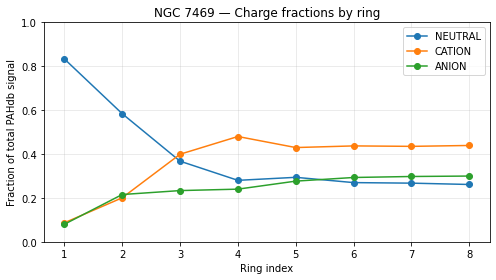

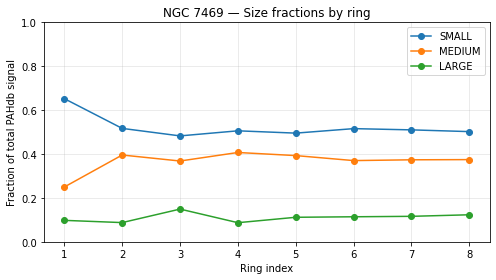

family    NEUTRAL  CATION  ANION  SMALL  MEDIUM  LARGE  CATION_NEUTRAL_RATIO  \
ring_idx                                                                       
1           0.834   0.087  0.080  0.652   0.250  0.098                 0.088   
2           0.584   0.201  0.215  0.517   0.396  0.088                 0.217   
3           0.367   0.399  0.233  0.483   0.368  0.149                 0.507   
4           0.280   0.480  0.240  0.506   0.407  0.087                 0.676   
5           0.294   0.430  0.277  0.495   0.393  0.112                 0.580   
6           0.270   0.437  0.293  0.516   0.370  0.114                 0.602   
7           0.267   0.435  0.298  0.510   0.374  0.116                 0.600   
8           0.261   0.439  0.300  0.502   0.375  0.123                 0.610   

family    ERROR            NC  
ring_idx                       
1         0.649  1.058691e+21  
2         0.506  1.240498e+20  
3         0.309  1.573633e+20  
4         0.253  1.475004e+20  
5      

In [8]:
# ===== Final plots & summary for NGC7469 =====
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

results_dir = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHDB_PAHonly_results_pypahdb\family_summaries")

df = pd.read_csv(results_dir / "all_rings_families.csv")

def ring_num(s):
    m = re.search(r"Ring(\d+)", s)
    return int(m.group(1)) if m else None

df["ring_idx"] = df["ring"].apply(ring_num)

# Charge fractions
plt.figure(figsize=(7,4))
for fam in ["NEUTRAL","CATION","ANION"]:
    sub = df[(df["category"]=="charge") & (df["family"]==fam)].sort_values("ring_idx")
    if not sub.empty:
        plt.plot(sub["ring_idx"], sub["fraction"], marker="o", label=fam)
plt.xlabel("Ring index")
plt.ylabel("Fraction of total PAHdb signal")
plt.title("NGC 7469 — Charge fractions by ring")
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Size fractions
plt.figure(figsize=(7,4))
for fam in ["SMALL","MEDIUM","LARGE"]:
    sub = df[(df["category"]=="size") & (df["family"]==fam)].sort_values("ring_idx")
    if not sub.empty:
        plt.plot(sub["ring_idx"], sub["fraction"], marker="o", label=fam)
plt.xlabel("Ring index")
plt.ylabel("Fraction of total PAHdb signal")
plt.title("NGC 7469 — Size fractions by ring")
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Export compact summary table
charge = (df[df["category"]=="charge"]
          .pivot_table(index="ring_idx", columns="family", values="fraction")
          .reindex(columns=["NEUTRAL","CATION","ANION"]))
size = (df[df["category"]=="size"]
        .pivot_table(index="ring_idx", columns="family", values="fraction")
        .reindex(columns=["SMALL","MEDIUM","LARGE"]))
extra = (df[df["category"]=="extra"]
         .pivot_table(index="ring_idx", columns="family", values="value"))

summary = pd.concat([charge, size, extra], axis=1)
summary.to_csv(results_dir / "rings_charge_size_summary.csv", float_format="%.4f")
print(summary.round(3))
print(f"\nSaved: {results_dir / 'rings_charge_size_summary.csv'}")


In [4]:
# ================== pyPAHdb (PAH-only) → family fractions (charge/size/pure-subst) ==================
# Inputs expected: {galaxy}_Ring{i}_pahonly.fits (λ[um], flux[MJy/sr]) produced earlier
# Outputs: per-ring CSVs + all_rings_families.csv under .../family_summaries

from pathlib import Path
import re
import numpy as np
import pandas as pd

import astropy.units as u
from astropy.table import Table
from specutils import Spectrum1D

from pypahdb.decomposer import Decomposer

# AmesPAHdb for metadata (charge, n_c, notes → pure/substituted)
from amespahdbpythonsuite.amespahdb import AmesPAHdb
from importlib.resources import files as pkg_files

# ----------------------- CONFIG -----------------------
base_dir      = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
galaxy_name   = base_dir.name
pahonly_dir   = base_dir                                 # where {galaxy}_Ring{i}_pahonly.fits live
n_rings       = 8
rings_to_run  = range(1, n_rings + 1)

out_root = base_dir / "PAHDB_PAHonly_results_pypahdb" / "family_summaries"
out_root.mkdir(parents=True, exist_ok=True)

# Size cuts (by number of carbons, Nc). Adjust if you use different boundaries.
SMALL_MAX  = 50
MEDIUM_MAX = 96

# ----------------------- Helpers: robust weight parsing -----------------------
def _as_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default

def _vectorize_weights_like_uids(uids, weights):
    """
    Return 1-D float array aligned with uids. Handles dict/list/ndarray/list-of-dicts, etc.
    """
    # dict {uid: weight}
    if isinstance(weights, dict):
        return np.asarray(
            [_as_float(weights.get(uid, weights.get(int(uid), weights.get(str(uid), np.nan)))) for uid in uids],
            dtype=float
        )

    # simple array-like
    try:
        arr = np.asarray(weights, dtype=float)
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        if arr.size == len(uids):
            return arr
    except Exception:
        pass

    # list of dicts the same length as uids
    if isinstance(weights, (list, tuple)) and len(weights) == len(uids):
        vals = []
        for w in weights:
            if isinstance(w, dict):
                if "weight" in w:
                    vals.append(_as_float(w["weight"]))
                elif "w" in w:
                    vals.append(_as_float(w["w"]))
                else:
                    # first numeric value fallback
                    num = None
                    for v in w.values():
                        if isinstance(v, (int, float, np.floating)):
                            num = v; break
                    vals.append(_as_float(num))
            else:
                vals.append(_as_float(w))
        return np.asarray(vals, dtype=float)

    # try to find an axis matching len(uids)
    try:
        arr = np.asarray(weights, dtype=float)
        axes = [i for i, n in enumerate(arr.shape) if n == len(uids)]
        if axes:
            ax = axes[0]
            moved = np.moveaxis(arr, ax, 0)
            slicer = tuple(0 for _ in range(moved.ndim - 1))
            vec = moved[(slice(None),) + slicer]
            return np.asarray(vec, dtype=float).reshape(-1)
    except Exception:
        pass

    # give up → NaNs
    return np.full(len(uids), np.nan, dtype=float)

def uids_and_weights_from_fit(fit):
    uids = np.asarray(fit.getuids())
    w = fit.getweights()
    if hasattr(w, "value"):
        w = w.value
    if hasattr(w, "data"):
        try:
            w = w.data
        except Exception:
            pass
    w = _vectorize_weights_like_uids(uids, w)
    return uids, w

# ----------------------- Helpers: Ames metadata → categories -----------------------
# Load Ames PAHdb XML shipped with the suite
xml_path = pkg_files("amespahdbpythonsuite").joinpath("resources/pahdb-theoretical_cutdown.xml")
pahdb = AmesPAHdb(filename=str(xml_path), check=False, cache=False)

def get_species_info(uid):
    # species dict has keys like 'charge', 'nc' (or 'n_c'), 'notes' / 'description' / 'class'
    sp = pahdb.getspeciesbyuid([int(uid)])
    if isinstance(sp, dict) and "data" in sp:
        sp = sp["data"][0] if sp["data"] else {}
    return sp

def charge_family(sp):
    # common values: 0 neutral, +1 cation, -1 anion (handle strings too)
    c = sp.get("charge", None)
    try:
        c = int(c)
    except Exception:
        # sometimes 'neutral', 'cation', 'anion'
        if isinstance(c, str):
            s = c.lower()
            if "cat" in s or "+" in s: return "CATION"
            if "ani" in s or "-" in s: return "ANION"
            return "NEUTRAL"
        return "UNKNOWN"
    if c > 0: return "CATION"
    if c < 0: return "ANION"
    return "NEUTRAL"

def carbon_count(sp):
    # prefer 'n_c', else 'nc', else try to parse formula
    for k in ("n_c", "nc", "nc_", "Nc"):
        if k in sp:
            try: return int(sp[k])
            except Exception: pass
    # fallback: parse formula like C54H18
    f = sp.get("formula") or sp.get("chemical_formula")
    if isinstance(f, str):
        m = re.search(r"[Cc]\s*(\d+)", f)
        if m: return int(m.group(1))
    return None

def size_family(sp):
    nc = carbon_count(sp)
    if nc is None:
        return "UNKNOWN"
    if nc <= SMALL_MAX: return "SMALL"
    if nc <= MEDIUM_MAX: return "MEDIUM"
    return "LARGE"

PURE_KEYWORDS = ("pure",)  # if explicitly marked
SUBST_KEYWORDS = (
    "substitu", "side", "alkyl", "methyl", "ethyl", "propyl", "butyl",
    "nitr", "amine", "oxo", "hydroxy", "carbonyl", "hetero", "pyridin",
    "aza", "quinone", "oxygen", "nitrogen", "sil", "metal"
)
def purity_family(sp):
    # Heuristic: scan descriptive fields
    text = " ".join(
        str(sp.get(k, "")) for k in ("notes","description","class","comment","type")
    ).lower()
    # If any "subst" keyword found → SUBSTITUTED
    if any(k in text for k in SUBST_KEYWORDS):
        return "SUBSTITUTED"
    # If it says 'pure' explicitly; else assume PURE for PAH core molecules
    if any(k in text for k in PURE_KEYWORDS):
        return "PURE"
    return "PURE"

# ----------------------- Aggregation helpers -----------------------
def accumulate_by_categories(uids, weights):
    """
    Returns:
      totals: dict with keys ('charge','size','purity') → dict family→sum(weight)
      details: list of per-UID dict rows (uid, weight, charge, size, purity, nc)
    """
    w = np.asarray(weights, dtype=float)
    if w.ndim > 1: w = w.reshape(-1)
    totals = {"charge":{}, "size":{}, "purity":{}}
    details = []

    for uid, wi in zip(uids, w):
        sp = get_species_info(uid)
        fam_c = charge_family(sp)
        fam_s = size_family(sp)
        fam_p = purity_family(sp)
        nc    = carbon_count(sp)

        totals["charge"][fam_c] = totals["charge"].get(fam_c, 0.0) + wi
        totals["size"][fam_s]   = totals["size"].get(fam_s, 0.0) + wi
        totals["purity"][fam_p] = totals["purity"].get(fam_p, 0.0) + wi

        details.append({
            "uid": int(uid),
            "weight": float(wi),
            "charge": fam_c,
            "size": fam_s,
            "purity": fam_p,
            "Nc": nc
        })
    return totals, details

def normalize_family_totals(totals):
    out = {}
    for cat, d in totals.items():
        s = float(np.nansum(list(d.values()))) if len(d) else 0.0
        out[cat] = {k: (v/s if s>0 else np.nan) for k, v in d.items()}
    return out

# ----------------------- Main loop over rings -----------------------
stack_rows = []  # for all_rings_families.csv

for i in rings_to_run:
    in_path = pahonly_dir / f"{galaxy_name}_Ring{i}_pahonly.fits"
    if not in_path.exists():
        print(f"[SKIP] Ring {i}: missing {in_path.name}")
        continue

    # Load PAH-only spectrum (um, MJy/sr)
    tab = Table.read(in_path, hdu=1)
    w_um   = np.asarray(tab["wavelength"], dtype=float)
    f_mjsr = np.asarray(tab["flux"], dtype=float)

    # Build Spectrum1D (1,1,Nλ) flux so pyPAHdb is happy; set colnames for plotting
    spec = Spectrum1D(
        spectral_axis = w_um * u.um,
        flux          = (f_mjsr[np.newaxis, np.newaxis, :] * (u.MJy / u.sr))
    )
    spec.meta["colnames"] = ["Wavelength", "Flux"]

    # Fit with pyPAHdb
    fit = Decomposer(spec)

    # Robustly get per-UID weights
    try:
        uids, weights = uids_and_weights_from_fit(fit)
        if weights.size != len(uids) or not np.isfinite(weights).any():
            raise RuntimeError("Bad weights vector.")
    except Exception as e:
        print(f"[WARN] Ring {i}: cannot get per-UID weights ({e}); skipping.")
        continue

    # Aggregate
    totals, details = accumulate_by_categories(uids, weights)
    fracs = normalize_family_totals(totals)

    # Write per-UID details
    det_df = pd.DataFrame(details)
    det_csv = out_root / f"Ring{i}_uids_detail.csv"
    det_df.to_csv(det_csv, index=False)

    # Write per-ring family fractions (stackable)
    rows = []
    for fam, frac in fracs["charge"].items():
        rows.append({"ring": f"Ring{i}", "category":"charge", "family":fam, "fraction":frac})
    for fam, frac in fracs["size"].items():
        rows.append({"ring": f"Ring{i}", "category":"size", "family":fam, "fraction":frac})
    for fam, frac in fracs["purity"].items():
        rows.append({"ring": f"Ring{i}", "category":"purity", "family":fam, "fraction":frac})

    ring_df = pd.DataFrame(rows)
    ring_csv = out_root / f"Ring{i}_families.csv"
    ring_df.to_csv(ring_csv, index=False)

    stack_rows.extend(rows)
    print(f"[OK] Ring {i}: wrote {det_csv.name} and {ring_csv.name}")

# ----------------------- Stacked CSV across all rings -----------------------
if stack_rows:
    all_df = pd.DataFrame(stack_rows)
    all_df.to_csv(out_root / "all_rings_families.csv", index=False)
    print(f"[DONE] Stacked: {out_root / 'all_rings_families.csv'}")
else:
    print("[WARN] No rings processed; nothing to stack.")


                 AmesPAHdbPythonSuite
                 
                          by
                          
                Dr. Christiaan Boersma
                
                          and
                         
             Dr. Alexandros Maragkoudakis
             
               Dr. Matthew J. Shannanon
               
                  Dr. Joseph E. Roser
                 

          SUITE VERSION: 0.5.0.post68+g606dd09         

                  CHECKING FOR UPDATE                  

                  NO UPDATE AVAILABLE                  

           WEBSITE: WWW.ASTROCHEM.ORG/PAHDB/           

          CONTACT: CHRISTIAAN.BOERSMA@NASA.GOV         

     PARSING DATABASE: THIS MAY TAKE A FEW MINUTES     

==
FILENAME                    : C:\Users\Juan\AppData\Local\Temp/c9d3854cd2fee02eb49a3c650e432db2.pkl
PARSE TIME                  : 0:00:00.072398
VERSION (DATE)              : 3.10 (2019-02-14)
COMMENT                     : 

This is the NASA Ames PAH IR Spectros

In [5]:
# ================== pyPAHdb (PAH-only) → family fractions with robust UID/weight fallback ==================
from pathlib import Path
import re
import tempfile
import numpy as np
import pandas as pd

import astropy.units as u
from astropy.table import Table
from astropy.io import fits
from specutils import Spectrum1D

from pypahdb.decomposer import Decomposer
from amespahdbpythonsuite.amespahdb import AmesPAHdb
from importlib.resources import files as pkg_files

# ----------------------- CONFIG -----------------------
base_dir      = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
galaxy_name   = base_dir.name
pahonly_dir   = base_dir
n_rings       = 8
rings_to_run  = range(1, n_rings + 1)

out_root = base_dir / "PAHDB_PAHonly_results_pypahdb" / "family_summaries"
out_root.mkdir(parents=True, exist_ok=True)

SMALL_MAX  = 50
MEDIUM_MAX = 96

# ----------------------- Ames DB (for charge/size/purity by UID) -----------------------
xml_path = pkg_files("amespahdbpythonsuite").joinpath("resources/pahdb-theoretical_cutdown.xml")
pahdb = AmesPAHdb(filename=str(xml_path), check=False, cache=False)

def _species(uid):
    sp = pahdb.getspeciesbyuid([int(uid)])
    if isinstance(sp, dict) and "data" in sp:
        return (sp["data"][0] if sp["data"] else {})
    return sp if isinstance(sp, dict) else {}

def _charge(sp):
    c = sp.get("charge", None)
    try:
        c = int(c)
        return "CATION" if c>0 else ("ANION" if c<0 else "NEUTRAL")
    except Exception:
        if isinstance(c, str):
            s=c.lower()
            if "cat" in s or "+" in s: return "CATION"
            if "ani" in s or "-" in s: return "ANION"
        return "NEUTRAL"

def _nc(sp):
    for k in ("n_c","nc","Nc","nc_"):
        if k in sp:
            try: return int(sp[k])
            except: pass
    f = sp.get("formula") or sp.get("chemical_formula")
    if isinstance(f, str):
        m = re.search(r"[Cc]\s*(\d+)", f); 
        return int(m.group(1)) if m else None
    return None

def _size(sp):
    nc = _nc(sp)
    if nc is None: return "UNKNOWN"
    if nc <= SMALL_MAX: return "SMALL"
    if nc <= MEDIUM_MAX: return "MEDIUM"
    return "LARGE"

SUBST_KEYS = (
    "substitu","side","alkyl","methyl","ethyl","propyl","butyl",
    "nitr","amine","oxo","hydroxy","carbonyl","hetero","pyridin",
    "aza","quinone","oxygen","nitrogen","sil","metal"
)
def _purity(sp):
    text = " ".join(str(sp.get(k,"")) for k in ("notes","description","class","comment","type")).lower()
    return "SUBSTITUTED" if any(k in text for k in SUBST_KEYS) else "PURE"

# ----------------------- Decomposer → try get UIDs/weights -----------------------
def get_uids_weights(fit_obj):
    """
    Tries multiple strategies:
      1) Public methods (getuids / getweights)
      2) Common private attrs (uids / weights / _uids / _weights / _Decomposer__*)
      3) Save to temp FITS and read 'COMPONENTS' / any BinTable with UID/WEIGHT columns
    Returns (uids ndarray, weights ndarray) or (None, None) if not available.
    """
    # 1) public
    for attr in ("getuids", "uids"):
        f = getattr(fit_obj, attr, None)
        if callable(f):
            try:
                uids = np.asarray(f())
                break
            except Exception:
                uids = None
        elif f is not None:
            uids = np.asarray(f)
            break
    else:
        uids = None

    for attr in ("getweights", "weights"):
        f = getattr(fit_obj, attr, None)
        if callable(f):
            try:
                w = f()
            except Exception:
                w = None
        else:
            w = f

    def _to_1d_float(x):
        if x is None: return None
        try:
            arr = np.asarray(x, dtype=float)
        except Exception:
            try:
                arr = np.asarray(x).astype(float, copy=False)
            except Exception:
                return None
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        return arr

    uids_arr = _to_1d_float(uids) if uids is not None else None
    w_arr    = _to_1d_float(w)    if 'w' in locals() else None

    if uids_arr is not None and w_arr is not None and uids_arr.size == w_arr.size:
        return uids_arr.astype(int), w_arr

    # 2) common private names
    cand_u = ["_uids","_Decomposer__uids","_Fitted__uids","uids"]
    cand_w = ["_weights","_Decomposer__weights","_Fitted__weights","weights"]
    for au in cand_u:
        if hasattr(fit_obj, au):
            uids_arr = _to_1d_float(getattr(fit_obj, au))
            if uids_arr is not None: break
    for aw in cand_w:
        if hasattr(fit_obj, aw):
            w_arr = _to_1d_float(getattr(fit_obj, aw))
            if w_arr is not None: break
    if uids_arr is not None and w_arr is not None and uids_arr.size == w_arr.size:
        return uids_arr.astype(int), w_arr

    # 3) temp FITS
    try:
        with tempfile.TemporaryDirectory() as td:
            tmp = Path(td) / "tmp_pypahdb_fit.fits"
            # header optional; just write file
            fit_obj.save_fits(str(tmp))
            with fits.open(tmp) as hdul:
                # prefer COMP/COMPONENTS table
                for h in hdul:
                    if (hasattr(h, "columns") and h.columns is not None):
                        cols = [c.name.upper() for c in h.columns]
                        if "UID" in cols and ("WEIGHT" in cols or "WEIGHTS" in cols):
                            uids_col = np.array(h.data["UID"]).astype(int)
                            wname = "WEIGHT" if "WEIGHT" in cols else "WEIGHTS"
                            w_col   = np.array(h.data[wname]).astype(float)
                            if uids_col.size == w_col.size:
                                return uids_col, w_col
                # secondary format: list-like (UIDS / WEIGHTS) in header?
                for h in hdul:
                    if isinstance(h, fits.BinTableHDU):
                        try:
                            uids_col = np.array(h.data["UIDS"]).astype(int)
                            w_col    = np.array(h.data["WEIGHTS"]).astype(float)
                            if uids_col.size == w_col.size:
                                return uids_col, w_col
                        except Exception:
                            pass
    except Exception:
        pass

    return None, None

# ----------------------- Aggregation -----------------------
def accumulate_by_uids(uids, weights):
    details = []
    tot_charge, tot_size, tot_purity = {}, {}, {}
    for uid, w in zip(uids, weights):
        sp = _species(uid)
        c  = _charge(sp)
        s  = _size(sp)
        p  = _purity(sp)
        nc = _nc(sp)

        tot_charge[c] = tot_charge.get(c, 0.0) + w
        tot_size[s]   = tot_size.get(s, 0.0) + w
        tot_purity[p] = tot_purity.get(p, 0.0) + w

        details.append({"uid": int(uid), "weight": float(w), "charge": c, "size": s, "purity": p, "Nc": nc})
    return {"charge": tot_charge, "size": tot_size, "purity": tot_purity}, details

def normalize_totals(d):
    out = {}
    for cat, sub in d.items():
        s = float(np.nansum(list(sub.values()))) if sub else 0.0
        out[cat] = {k: (v/s if s>0 else np.nan) for k, v in sub.items()}
    return out

# Fallback: read scalar family HDUs from pypahdb FITS (NEUTRAL/CATION/ANION + SMALL/MEDIUM/LARGE)
FAMILY_SCALAR_KEYS = {
    "charge": ["NEUTRAL","CATION","ANION"],
    "size":   ["SMALL","MEDIUM","LARGE"],
}

def read_scalar_families_from_fits(fits_path):
    vals = {"charge":{}, "size":{}}
    with fits.open(fits_path) as hdul:
        for cat, names in FAMILY_SCALAR_KEYS.items():
            for name in names:
                h = next((h for h in hdul if h.name.upper()==name), None)
                if h is not None and h.data is not None:
                    try:
                        vals[cat][name] = float(np.nanmean(h.data))
                    except Exception:
                        vals[cat][name] = np.nan
    # normalize
    fracs = {}
    for cat, sub in vals.items():
        s = float(np.nansum(list(sub.values()))) if sub else 0.0
        fracs[cat] = {k: (v/s if s>0 else np.nan) for k, v in sub.items()}
    return fracs

# ----------------------- Main -----------------------
stack_rows = []

for i in rings_to_run:
    in_path = pahonly_dir / f"{galaxy_name}_Ring{i}_pahonly.fits"
    if not in_path.exists():
        print(f"[SKIP] Ring {i}: missing {in_path.name}")
        continue

    tab   = Table.read(in_path, hdu=1)
    w_um  = np.asarray(tab["wavelength"], dtype=float)
    f_ms  = np.asarray(tab["flux"], dtype=float)

    spec = Spectrum1D(
        spectral_axis = w_um * u.um,
        flux          = (f_ms[np.newaxis, np.newaxis, :] * (u.MJy / u.sr))
    )
    spec.meta["colnames"] = ["Wavelength", "Flux"]

    fit = Decomposer(spec)

    # Try to get UIDs/weights
    uids, weights = get_uids_weights(fit)

    if uids is not None and weights is not None and uids.size == weights.size and np.isfinite(weights).any():
        # Per-UID path → charge/size/purity available
        totals, details = accumulate_by_uids(uids, weights)
        fracs = normalize_totals(totals)

        # details CSV
        det_df  = pd.DataFrame(details)
        det_csv = out_root / f"Ring{i}_uids_detail.csv"
        det_df.to_csv(det_csv, index=False)

        # stackable rows (charge/size/purity)
        rows = []
        for fam, frac in fracs["charge"].items():
            rows.append({"ring": f"Ring{i}", "category":"charge", "family":fam, "fraction":frac})
        for fam, frac in fracs["size"].items():
            rows.append({"ring": f"Ring{i}", "category":"size", "family":fam, "fraction":frac})
        for fam, frac in fracs["purity"].items():
            rows.append({"ring": f"Ring{i}", "category":"purity", "family":fam, "fraction":frac})
        pd.DataFrame(rows).to_csv(out_root / f"Ring{i}_families.csv", index=False)

        stack_rows.extend(rows)
        print(f"[OK] Ring {i}: per-UID families written (incl. purity).")

    else:
        # Fallback: write temp pypahdb FITS, read scalar family HDUs
        with tempfile.TemporaryDirectory() as td:
            tmpf = Path(td) / f"{galaxy_name}_Ring{i}_pypahdb_tmp.fits"
            fit.save_fits(str(tmpf))
            fracs = read_scalar_families_from_fits(tmpf)

        rows = []
        # charge & size available; purity not available without UIDs
        for fam, frac in fracs.get("charge", {}).items():
            rows.append({"ring": f"Ring{i}", "category":"charge", "family":fam, "fraction":frac})
        for fam, frac in fracs.get("size", {}).items():
            rows.append({"ring": f"Ring{i}", "category":"size", "family":fam, "fraction":frac})
        pd.DataFrame(rows).to_csv(out_root / f"Ring{i}_families.csv", index=False)

        stack_rows.extend(rows)
        print(f"[OK] Ring {i}: no UID access; wrote charge/size from scalar HDUs (purity skipped).")

# Stacked CSV
if stack_rows:
    all_df = pd.DataFrame(stack_rows)
    all_df.to_csv(out_root / "all_rings_families.csv", index=False)
    print(f"[DONE] Stacked: {out_root / 'all_rings_families.csv'}")
else:
    print("[WARN] No rings processed; nothing to stack.")


                 AmesPAHdbPythonSuite
                 
                          by
                          
                Dr. Christiaan Boersma
                
                          and
                         
             Dr. Alexandros Maragkoudakis
             
               Dr. Matthew J. Shannanon
               
                  Dr. Joseph E. Roser
                 

          SUITE VERSION: 0.5.0.post68+g606dd09         

           WEBSITE: WWW.ASTROCHEM.ORG/PAHDB/           

          CONTACT: CHRISTIAAN.BOERSMA@NASA.GOV         

     PARSING DATABASE: THIS MAY TAKE A FEW MINUTES     

==
FILENAME                    : C:\Users\Juan\AppData\Local\Temp/c9d3854cd2fee02eb49a3c650e432db2.pkl
PARSE TIME                  : 0:00:00.126583
VERSION (DATE)              : 3.10 (2019-02-14)
COMMENT                     : 

This is the NASA Ames PAH IR Spectroscopic Database. The contents of
the database are described in Bauschlicher et al. (2010) and Boersma
et al. (2014)

In [2]:
# ================== AmesPAHdbPythonSuite on PAH-only spectra (charge/size/purity) ==================
from pathlib import Path
import re
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii  # <-- FIXED: use astropy.io.ascii
from specutils import Spectrum1D

# Ames PAH DB (full suite, not pyPAHdb)
from amespahdbpythonsuite.amespahdb import AmesPAHdb
from amespahdbpythonsuite import observation

# ----------------------- CONFIG -----------------------
base_dir     = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
galaxy_name  = base_dir.name
pahonly_dir  = base_dir                                 # where NGC7469_Ring{i}_pahonly.fits live
out_root     = base_dir / "AMES_from_PAHonly"           # outputs here
out_root.mkdir(parents=True, exist_ok=True)

n_rings      = 8
rings_to_run = range(1, n_rings + 1)

# Fitting/config knobs
USE_CASCADE_EV   = 6.0     # mean absorbed energy [eV] for cascade()
GAUSS_FWHM_CM1   = 20.0    # Gaussian FWHM in 1/cm for convolve()
GLOBAL_SHIFT_CM1 = -15.0   # database -> observation wavenumber global shift
SMALL_MAX        = 50      # Nc thresholds for size binning
MEDIUM_MAX       = 96

# ----------------------- Load Ames database -----------------------
from importlib.resources import files as pkg_files
xml_path = pkg_files("amespahdbpythonsuite").joinpath("resources/pahdb-theoretical_cutdown.xml")
pahdb = AmesPAHdb(filename=str(xml_path), check=False, cache=False)

# ----------------------- Helpers: species classification -----------------------
def _species(uid: int):
    sp = pahdb.getspeciesbyuid([int(uid)])
    if isinstance(sp, dict) and "data" in sp:
        return (sp["data"][0] if sp["data"] else {})
    return sp if isinstance(sp, dict) else {}

def _charge(sp: dict) -> str:
    c = sp.get("charge", None)
    try:
        c = int(c)
        return "CATION" if c > 0 else ("ANION" if c < 0 else "NEUTRAL")
    except Exception:
        if isinstance(c, str):
            s = c.lower()
            if "cat" in s or "+" in s: return "CATION"
            if "ani" in s or "-" in s: return "ANION"
        return "NEUTRAL"

def _nc(sp: dict):
    for k in ("n_c","nc","Nc","nc_","N_C"):
        if k in sp:
            try: return int(sp[k])
            except: pass
    f = sp.get("formula") or sp.get("chemical_formula")
    if isinstance(f, str):
        m = re.search(r"[Cc]\s*(\d+)", f)
        if m: return int(m.group(1))
    return None

def _size(sp: dict) -> str:
    nc = _nc(sp)
    if nc is None: return "UNKNOWN"
    if nc <= SMALL_MAX:  return "SMALL"
    if nc <= MEDIUM_MAX: return "MEDIUM"
    return "LARGE"

SUBST_KEYS = (
    "substitu","side","alkyl","methyl","ethyl","propyl","butyl",
    "nitr","amine","oxo","hydroxy","carbonyl","hetero","pyridin",
    "aza","quinone","oxygen","nitrogen","sil","metal"
)
def _purity(sp: dict) -> str:
    text = " ".join(str(sp.get(k,"")) for k in ("notes","description","class","comment","type")).lower()
    return "SUBSTITUTED" if any(k in text for k in SUBST_KEYS) else "PURE"

# ----------------------- Build Observation from (w_um, F[arbitrary]) -----------------------
def build_observation_from_arrays(w_um: np.ndarray, flux: np.ndarray):
    """
    Make an IPAC table with astropy.io.ascii using wavenumber grid (1/cm).
    Returns (Observation, wn_grid[1/cm]).
    """
    w_um  = np.asarray(w_um,  dtype=float)
    flux  = np.asarray(flux,  dtype=float)
    wn    = (1e4 / w_um)     # um -> 1/cm

    t = Table()
    t["wavenumber"] = wn * (1/u.cm)
    t["intensity"]  = flux * u.Jy

    tmp_dir  = out_root / "tmp_ipac"
    tmp_dir.mkdir(exist_ok=True)
    ipac_path = tmp_dir / "obs.ipac"
    ascii.write(t, ipac_path, format="ipac", overwrite=True)

    obs = observation.Observation(str(ipac_path))
    obs.abscissaunitsto("1/cm")
    return obs, wn

# ----------------------- Fit one ring -----------------------
def fit_ring_with_ames(ring_idx: int):
    fits_in = pahonly_dir / f"{galaxy_name}_Ring{ring_idx}_pahonly.fits"
    if not fits_in.exists():
        print(f"[SKIP] Ring {ring_idx}: missing {fits_in.name}")
        return None

    # Load PAH-only spectrum
    tab   = Table.read(fits_in, hdu=1)
    w_um  = np.asarray(tab["wavelength"], dtype=float)
    f_mjsr= np.asarray(tab["flux"],      dtype=float)
    obs, wn_grid = build_observation_from_arrays(w_um, f_mjsr)

    # All species; optionally narrow with queries (e.g., "Nc>20 & Nc<120")
    uids = pahdb.search("all")
    trans = pahdb.gettransitionsbyuid(uids)

    # Cascade emission & spectral shift
    trans.cascade(USE_CASCADE_EV * 1.603e-12, multiprocessing=False)
    if GLOBAL_SHIFT_CM1:
        trans.shift(GLOBAL_SHIFT_CM1)

    # Convolve transitions to observation grid and fit
    spec = trans.convolve(grid=obs.getgrid(), fwhm=GAUSS_FWHM_CM1, gaussian=True, multiprocessing=False)
    fit  = spec.fit(obs)

    # UIDs & weights from Fitted
    used_uids = np.asarray(fit.getuids()).astype(int)
    weights   = np.asarray(fit.getweights(), dtype=float)

    rows = []
    for uid, w in zip(used_uids, weights):
        sp = _species(int(uid))
        rows.append({
            "uid": int(uid),
            "weight": float(w),
            "charge": _charge(sp),
            "size":   _size(sp),
            "purity": _purity(sp),
            "Nc":     _nc(sp),
        })
    df_detail = pd.DataFrame(rows)
    df_detail.to_csv(out_root / f"Ring{ring_idx}_AMES_uids_detail.csv", index=False)

    def frac_by(key):
        t = df_detail.groupby(key)["weight"].sum()
        s = t.sum()
        return (t/s).reindex(sorted(t.index)).to_dict() if s>0 else {}

    f_charge = frac_by("charge")
    f_size   = frac_by("size")
    f_purity = frac_by("purity")

    ring_rows = []
    for fam, val in f_charge.items():
        ring_rows.append({"ring": f"Ring{ring_idx}", "category": "charge", "family": fam, "fraction": float(val)})
    for fam, val in f_size.items():
        ring_rows.append({"ring": f"Ring{ring_idx}", "category": "size", "family": fam, "fraction": float(val)})
    for fam, val in f_purity.items():
        ring_rows.append({"ring": f"Ring{ring_idx}", "category": "purity", "family": fam, "fraction": float(val)})
    pd.DataFrame(ring_rows).to_csv(out_root / f"Ring{ring_idx}_AMES_families.csv", index=False)

    summary = {
        "ring": f"Ring{ring_idx}",
        "NEUTRAL": f_charge.get("NEUTRAL", np.nan),
        "CATION":  f_charge.get("CATION",  np.nan),
        "ANION":   f_charge.get("ANION",   np.nan),
        "SMALL":   f_size.get("SMALL",   np.nan),
        "MEDIUM":  f_size.get("MEDIUM",  np.nan),
        "LARGE":   f_size.get("LARGE",   np.nan),
        "PURE":        f_purity.get("PURE",        np.nan),
        "SUBSTITUTED": f_purity.get("SUBSTITUTED", np.nan),
    }
    return summary

# ----------------------- Run all rings & stack -----------------------
all_summaries = []
for i in rings_to_run:
    try:
        s = fit_ring_with_ames(i)
        if s is not None:
            all_summaries.append(s)
            print(f"[OK] Ring {i}: families (charge/size/purity) computed.")
    except Exception as e:
        print(f"[WARN] Ring {i}: Ames fit failed → {e}")

if all_summaries:
    df = pd.DataFrame(all_summaries)
    df.to_csv(out_root / "rings_charge_size_purity_summary_AMES.csv", index=False, float_format="%.6f")

    long_rows = []
    for s in all_summaries:
        ring = s["ring"]
        for fam in ("NEUTRAL","CATION","ANION"):
            long_rows.append({"ring": ring, "category":"charge","family":fam,"fraction": s.get(fam, np.nan)})
        for fam in ("SMALL","MEDIUM","LARGE"):
            long_rows.append({"ring": ring, "category":"size","family":fam,"fraction": s.get(fam, np.nan)})
        for fam in ("PURE","SUBSTITUTED"):
            long_rows.append({"ring": ring, "category":"purity","family":fam,"fraction": s.get(fam, np.nan)})
    pd.DataFrame(long_rows).to_csv(out_root / "all_rings_ames.csv", index=False, float_format="%.6f")
    print(f"[DONE] Wrote:\n  {out_root / 'rings_charge_size_purity_summary_AMES.csv'}\n  {out_root / 'all_rings_ames.csv'}")
else:
    print("[WARN] No rings processed.")


                 AmesPAHdbPythonSuite
                 
                          by
                          
                Dr. Christiaan Boersma
                
                          and
                         
             Dr. Alexandros Maragkoudakis
             
               Dr. Matthew J. Shannanon
               
                  Dr. Joseph E. Roser
                 

          SUITE VERSION: 0.5.0.post68+g606dd09         

           WEBSITE: WWW.ASTROCHEM.ORG/PAHDB/           

          CONTACT: CHRISTIAAN.BOERSMA@NASA.GOV         

     PARSING DATABASE: THIS MAY TAKE A FEW MINUTES     

==
FILENAME                    : C:\Users\Juan\AppData\Local\Temp/c9d3854cd2fee02eb49a3c650e432db2.pkl
PARSE TIME                  : 0:00:00.030926
VERSION (DATE)              : 3.10 (2019-02-14)
COMMENT                     : 

This is the NASA Ames PAH IR Spectroscopic Database. The contents of
the database are described in Bauschlicher et al. (2010) and Boersma
et al. (2014)